## Import Pacakges and Data

In [2]:
import os
import numpy as np
import pandas as pd
import pylab as plt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import KernelDensity
import math
from tqdm import tqdm
import time
from umap import UMAP
import scipy.stats as stats
import kaleido
import plotly
import plotly.graph_objects as go
import matplotlib.colors as mcolors
plt.rcParams['svg.fonttype'] = 'none'

In [3]:
home = "C:/Users/Patrick/OneDrive/GitHub Terminal/LanM_Ortholog_Analysis"
office = "C:/Users/diep5/OneDrive - LLNL/A. SpyTagCatcher Project/A.1 Python Scripts/Ortholog_Analysis/08-23-2024, Final Material"

os.chdir(office)
cwd = os.getcwd()  

# Load the Excel file
df = pd.read_excel("08-23-2024, LanM Library (ULTIMATE).xlsx", nrows=624)

# Columns to check for empty values
columns_to_check = [
    'phylum_original',
    'class_original',
    'order_original',
    'family_original',
    'genus_original',
    'species_original'
]

# Replace empty values with 'unspecified' in the specified columns
df[columns_to_check] = df[columns_to_check].fillna('unspecified')

MexLanM1, MexLanM2, MexLanM3 = 622, 623, 624

In [4]:
df_stocks = pd.read_excel("02-05-2024, Metal Stock Measurements (5x to Match Sample Dilution, ULTIMATE).xlsx")

### Scatter Plot Function for Basic XY Plot

In [5]:
def scatterplot_xy(x, y, title="Scatter Plot", xlabel="X-axis", ylabel="Y-axis", hline=None):
    sns.scatterplot(x=x, y=y, data=df)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(loc='lower center', bbox_to_anchor=(1, 1))
    plt.legend(loc='lower center', bbox_to_anchor=(1, 1))
    if hline != None:
        plt.axhline(y=hline, color='black', linestyle='--', label='Horizontal Line')
    plt.show()

## Information Retrieval Function

In [6]:
def return_information(column_name, search_value, target_column, dataframe):
    """
    Returns information from a DataFrame based on a value within a specific column.

    Parameters:
    column_name (str): Name of the column where the search value is located.
    search_value (object): The value to search for within the specified column.
    target_column (str): Name of the column from which to retrieve information.
    dataframe (pandas.DataFrame): The DataFrame containing the data.

    Returns:
    object: The value located at the specified row and column.
    """
    try:
        row_index = dataframe[dataframe[column_name] == search_value].index[0]
        value = dataframe.loc[row_index, target_column]
        return print(f'ID:{search_value} {value}')
    except IndexError:
        return "Search value not found"
    except KeyError:
        return "Column name not found"
def get_values_for_duplicates(column_with_duplicates, column_to_extract, dataframe):
    """
    Returns a list of values from one column if there exist duplicates in another column.

    Parameters:
    column_with_duplicates (str): Name of the column containing the potential duplicates.
    column_to_extract (str): Name of the column from which to extract values.
    dataframe (pandas.DataFrame): The DataFrame containing the data.

    Returns:
    list: List of values from the specified column where duplicates exist in the other column.
    """
    duplicates = dataframe[dataframe.duplicated(subset=column_with_duplicates, keep=False)]
    values = duplicates[column_to_extract].tolist()
    return values
def get_duplicate_value(id_2_value, dataframe):
    """
    Checks if there exists a duplicate value in the 'Name' column for the given 'ID-2' value,
    and returns the 'ID-2' value of the duplicate, if found.

    Parameters:
    id_2_value (int): Value from the 'ID-2' column to check for duplicates.
    dataframe (pandas.DataFrame): The DataFrame containing the data.

    Returns:
    int or None: The 'ID-2' value of the duplicate, if found; otherwise, None.
    """
    try:
        name_value = dataframe.loc[dataframe['ID-2'] == id_2_value, 'Sequence (SP Removed)'].iloc[0]
        duplicate_id_2 = dataframe[dataframe['Sequence (SP Removed)'] == name_value]['ID-2']
        if len(duplicate_id_2) > 1:
            value = dataframe.loc[id_2_value, 'Sequence (SP Removed)']
            return print(f'Duplicate ID: {duplicate_id_2.tolist()[1]} \n'
                        f'Sequence of Duplicate: {value}')  # Assuming the first occurrence is not a duplicate
        else:
            return None
    except IndexError:
        return None
    except KeyError:
        return None

## All-Ortholog Scatter Plot Function with Shaded Error Regions

In [7]:
def scatterplot_xy_withHue(x, y, error, category, colour, title="Scatter Plot", xlabel="X-axis", ylabel="Y-axis", hline=None, errorbars=False):
    size_mapping = (20, 100)  # This makes the datapoints bigger than their defaults
    plt.figure(figsize=(12, 3))
    
    # Scatter plot with size parameter for errors
    ax = sns.scatterplot(x=x, y=y, hue=category, palette=colour, size=error, sizes=size_mapping, data=df)
    
    if errorbars:
        plt.errorbar(x=x, y=y, yerr=error, fmt='none', ecolor='gray', elinewidth=1, capsize=0)
        plt.ylim(0, 150)
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(-5, 630)
    
    # Major ticks
    plt.xticks(np.arange(0, 630, 50))
    plt.yticks(np.arange(0, 160, 25))
    
    # Minor ticks
    plt.minorticks_on()  # Enable minor ticks
    plt.tick_params(axis='x', which='minor', direction='out', length=2, color='black')
    plt.tick_params(axis='y', which='minor', direction='out', length=2, color='black')
       
    # Add horizontal line if specified
    if hline is not None:
        plt.axhline(y=hline, color='black', linestyle='--', label='Horizontal Line')
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, title="Legend")
    plt.savefig(f"12-10-2024, Individual mtot plot {category}.svg", format="svg")
    plt.show()

## DATA PROCESSING STEP 1 (df, Mtot)

In [8]:
#sum the ppb values of the REEs across each replicate, and create a new column to store this
df['Total_Metal_Replicate_1'] = df.loc[:, "Y-1":"Lu-1"].sum(axis=1)
df['Total_Metal_Replicate_2'] = df.loc[:, "Y-2":"Lu-2"].sum(axis=1)
df['Total_Metal_Replicate_3'] = df.loc[:, "Y-3":"Lu-3"].sum(axis=1)

df['Total_Metal_Replicate_Average'] = (df['Total_Metal_Replicate_1']+
                                        df['Total_Metal_Replicate_2']+
                                        df['Total_Metal_Replicate_3'])/3

df['Total_Metal_Replicate_AverageRounded'] = np.ceil(df['Total_Metal_Replicate_Average'])

df['Total_Metal_Replicate_SD'] = (df[['Total_Metal_Replicate_1','Total_Metal_Replicate_2',
                                              'Total_Metal_Replicate_3']]).std(axis=1)

df['Total_Metal_Replicate_RSD'] = (df[['Total_Metal_Replicate_1',
                                       'Total_Metal_Replicate_2',
                                        'Total_Metal_Replicate_3']]).std(axis=1)/df['Total_Metal_Replicate_Average']*100

## THE FOLLOWING IS ONLY FOR NORMALIZED VALUES
# #get the peak metal capture value for replicates
# Total_Metal_Replicate_1_MAX = np.round(df["Total_Metal_Replicate_1"].max())
# Total_Metal_Replicate_2_MAX = np.round(df["Total_Metal_Replicate_2"].max())
# Total_Metal_Replicate_3_MAX = np.round(df["Total_Metal_Replicate_3"].max())
# Total_Metal_Avg = np.mean([Total_Metal_Replicate_1_MAX,Total_Metal_Replicate_2_MAX,Total_Metal_Replicate_3_MAX])

# # sum the ppb values of the REEs across each replicate, then divide each of these values
# # with the largest in the replicate above, and create a new column to store this data
# df['Total_Metal_Replicate_1_Normalized'] = df.loc[:, "Y-1":"Lu-1"].sum(axis=1)/Total_Metal_Replicate_1_MAX
# df['Total_Metal_Replicate_2_Normalized'] = df.loc[:, "Y-2":"Lu-2"].sum(axis=1)/Total_Metal_Replicate_2_MAX
# df['Total_Metal_Replicate_3_Normalized'] = df.loc[:, "Y-3":"Lu-3"].sum(axis=1)/Total_Metal_Replicate_3_MAX

# #caluclate statistics for this new data
# df['Total_Metal_Replicate_Average_Normalized'] = (df['Total_Metal_Replicate_1_Normalized']+
#                                                   df['Total_Metal_Replicate_2_Normalized']+
#                                                   df['Total_Metal_Replicate_3_Normalized'])/3
# df['Total_Metal_Replicate_SD_Normalized'] = (df[['Total_Metal_Replicate_1_Normalized','Total_Metal_Replicate_2_Normalized',
#                                               'Total_Metal_Replicate_3_Normalized']]).std(axis=1) #/df['Total_Metal_Replicate_Average_Normalized']*100 if you want the RSD

# df.to_csv('08-28-2024, updated master sheet test 1.csv', index=False)

### Full Ortholog Mtot Plot

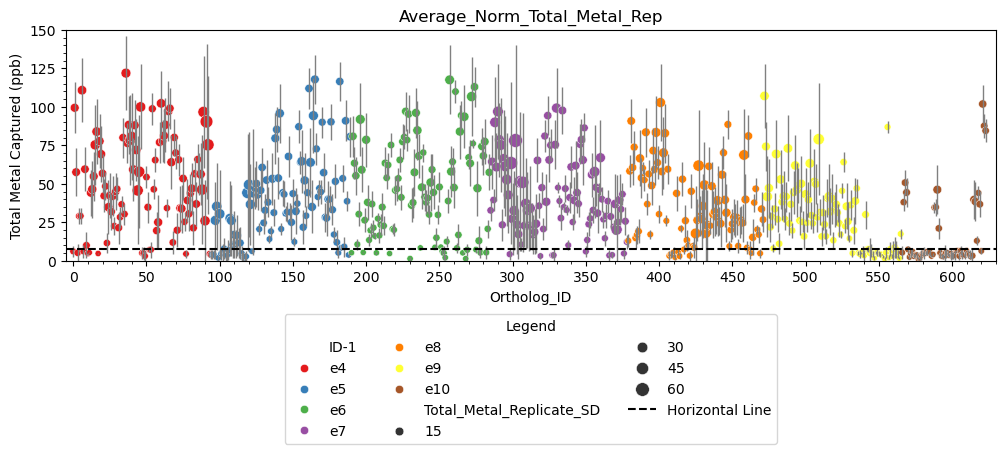

In [9]:
#SELECT CATEGORY OF INTEREST HERE
which_palette_1 = "Set1"
category_of_interest1 = "ID-1"
count1 = df[category_of_interest1].nunique()

scatterplot_xy_withHue(df["ID-6"], df['Total_Metal_Replicate_Average'], df['Total_Metal_Replicate_SD'], 
                       category = category_of_interest1, 
                       colour = sns.color_palette(which_palette_1,count1), 
                       title="Average_Norm_Total_Metal_Rep", 
                       xlabel="Ortholog_ID", 
                       ylabel="Total Metal Captured (ppb)",
                       hline = 7.5,
                       errorbars = True)

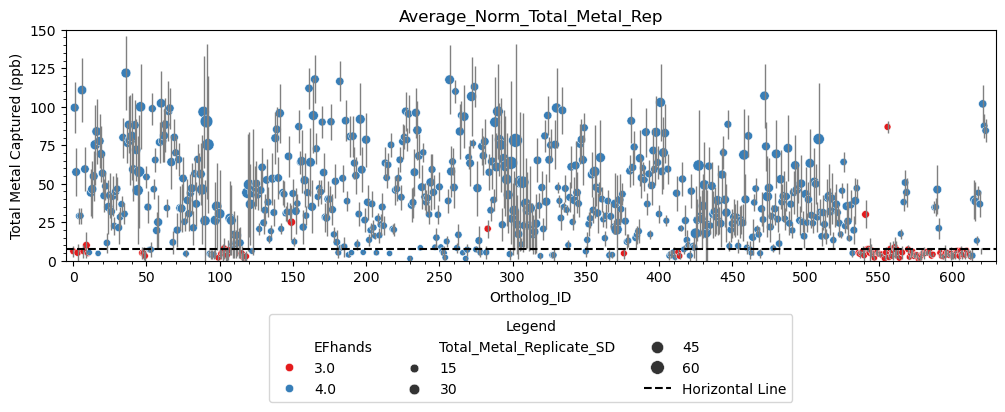

In [22]:
#SELECT CATEGORY OF INTEREST HERE
which_palette_1 = "Set1"
category_of_interest1 = "EFhands"
count1 = df[category_of_interest1].nunique()

scatterplot_xy_withHue(df["ID-6"], df['Total_Metal_Replicate_Average'], df['Total_Metal_Replicate_SD'], 
                       category = category_of_interest1, 
                       colour = sns.color_palette(which_palette_1,count1), 
                       title="Average_Norm_Total_Metal_Rep", 
                       xlabel="Ortholog_ID", 
                       ylabel="Total Metal Captured (ppb)",
                       hline = 7.5,
                       errorbars = True)

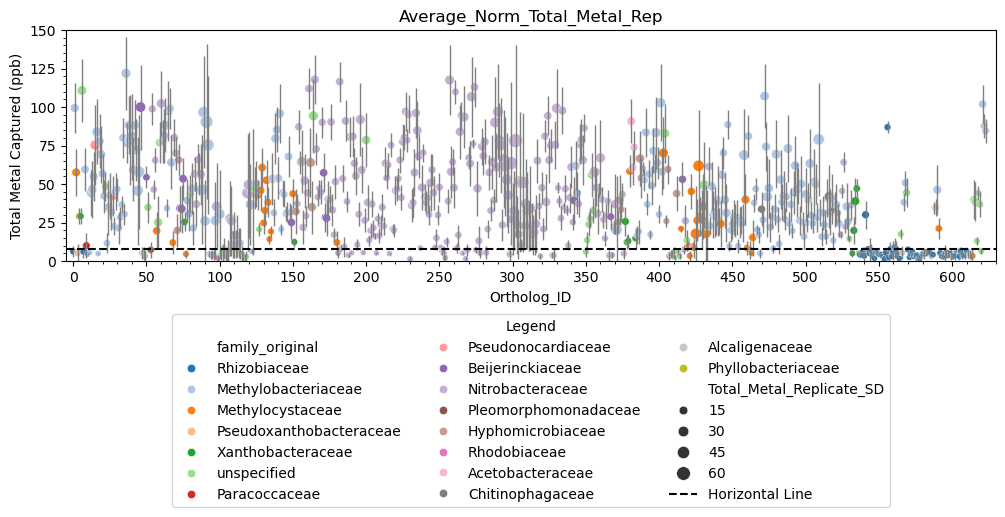

In [23]:
#SELECT CATEGORY OF INTEREST HERE
which_palette_1 = "tab20"
category_of_interest1 = "family_original"
count1 = df[category_of_interest1].nunique()

scatterplot_xy_withHue(df["ID-6"], df['Total_Metal_Replicate_Average'], df['Total_Metal_Replicate_SD'], 
                       category = category_of_interest1, 
                       colour = sns.color_palette(which_palette_1,count1), 
                       title="Average_Norm_Total_Metal_Rep", 
                       xlabel="Ortholog_ID", 
                       ylabel="Total Metal Captured (ppb)",
                       hline = 7.5,
                       errorbars = True)

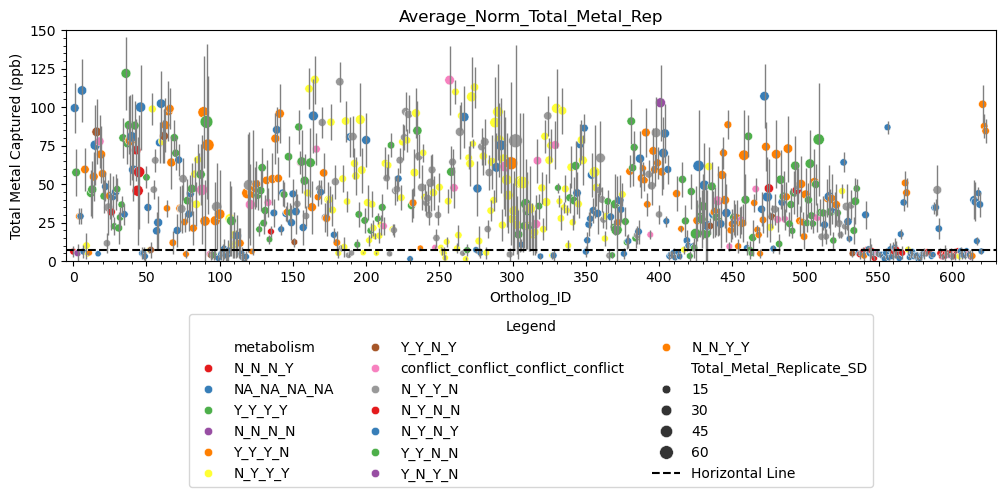

In [24]:
#SELECT CATEGORY OF INTEREST HERE
which_palette_1 = "Set1"
category_of_interest1 = "metabolism"
count1 = df[category_of_interest1].nunique()

scatterplot_xy_withHue(df["ID-6"], df['Total_Metal_Replicate_Average'], df['Total_Metal_Replicate_SD'], 
                       category = category_of_interest1, 
                       colour = sns.color_palette(which_palette_1,count1), 
                       title="Average_Norm_Total_Metal_Rep", 
                       xlabel="Ortholog_ID", 
                       ylabel="Total Metal Captured (ppb)",
                       hline = 7.5,
                       errorbars = True)

## QQ Analysis for Normality of Data Spread

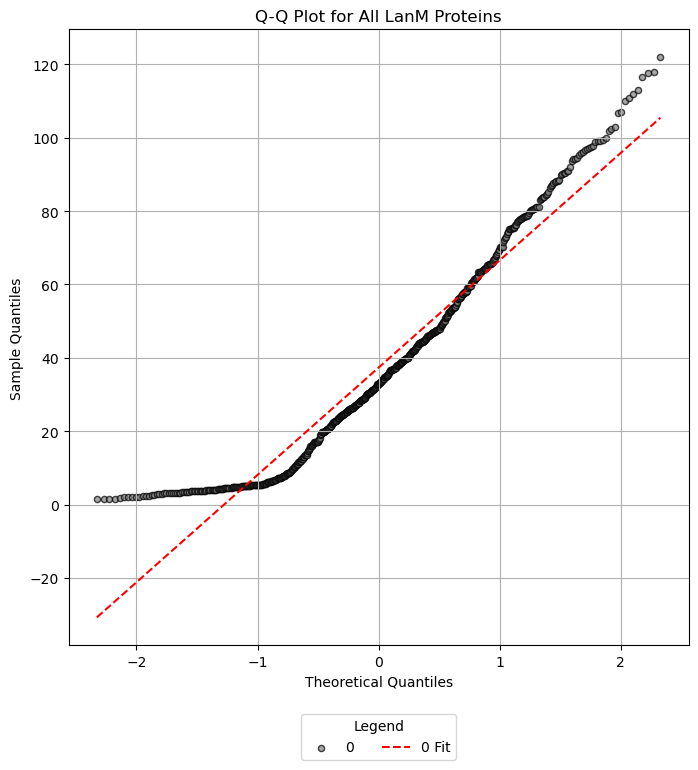

In [16]:
from sklearn.linear_model import LinearRegression
# Create the Q-Q plot and scatter points
plt.figure(figsize=(8, 8))

category_of_interest1 = 'ID-8'

# Overlay colored scatter points and fit lines
for label in df[category_of_interest1].unique():
    subset = df[df[category_of_interest1] == label]
    
    if subset.empty:
        continue  # Skip empty subsets
    
    subset_data = subset['Total_Metal_Replicate_Average']
    
    # Calculate quantiles for the subset
    subset_theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(subset_data)))
    subset_quantiles = np.sort(subset_data)
    
    # Scatter plot for the subset
    plt.scatter(subset_theoretical_quantiles,
                subset_quantiles,
                label=label,
                color='gray',         # Color of the datapoints
                s=20,                 # Size of the datapoints
                edgecolor='black',    # Edge color of the datapoints
                marker='o',           # Marker style
                alpha=0.7)            # Transparency of the datapoints
    
    # Fit a line to the quantiles for the subset
    model = LinearRegression()
    model.fit(subset_theoretical_quantiles.reshape(-1, 1), subset_quantiles)
    
    # Predict values for the line
    line_quantiles = np.linspace(subset_theoretical_quantiles.min(), subset_theoretical_quantiles.max(), 100)
    line_values = model.predict(line_quantiles.reshape(-1, 1))
    
    # Plot the line
    plt.plot(line_quantiles, line_values, label=f'{label} Fit', linestyle='--', color = 'red')

    # the text below can be (un)indented if you want a single plot containing everything/multiple plots, respectively
plt.title('Q-Q Plot for All LanM Proteins')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, title="Legend")
plt.grid(True)
plt.savefig(f"12-10-2024, Q-Q plot for all LanM proteins.svg", format="svg")
plt.show()

C:\Users\diep5\AppData\Local\Temp\ipykernel_13204\505642229.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[category_of_interest].fillna('unspecified', inplace=True)


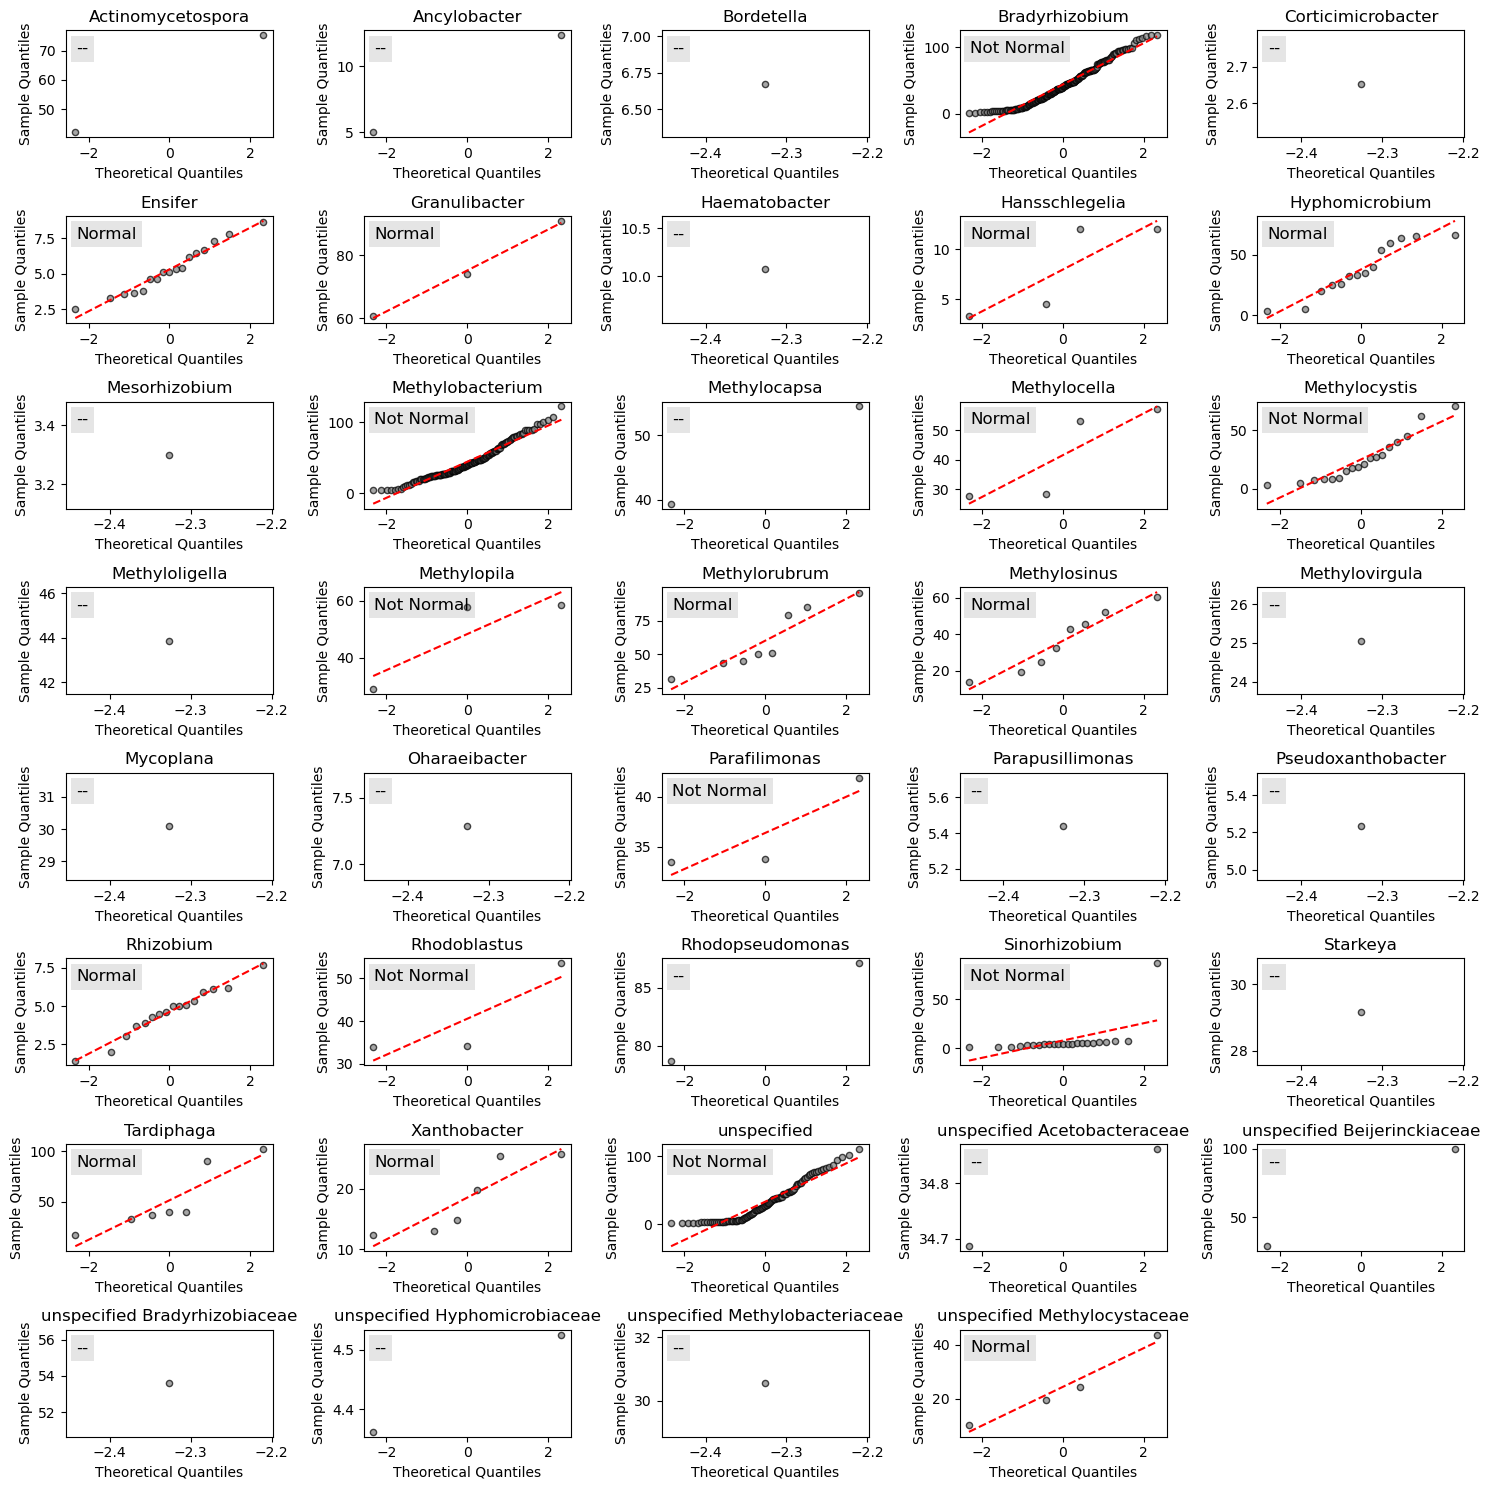

In [13]:
def shapiro_wilk_test(data):
    # Perform Shapiro-Wilk test
    statistic, p_value = stats.shapiro(data)
    return statistic, p_value

# Get the unique categories and sort them alphabetically
category_of_interest = 'genus_original'
df[category_of_interest].fillna('unspecified', inplace=True)
categories = sorted(df[category_of_interest].unique())

# Calculate the number of rows and columns for the grid
num_categories = len(categories)
num_cols = 5
num_rows = int(np.ceil(num_categories / num_cols))

# Create a grid of subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 15))
axes = axes.flatten()  # Flatten to easily iterate over

# Loop over each category and plot
for i, label in enumerate(categories):
    subset = df[df[category_of_interest] == label]
    
    if subset.empty:
        continue  # Skip empty subsets
    
    subset_data = subset['Total_Metal_Replicate_Average']
    
    # Perform normality test
    normality_result = None
    if len(subset_data) >= 3:
        statistic, p_value = shapiro_wilk_test(subset_data)
        normality_result = p_value > 0.05
        normality_text = f'Normal' if normality_result else f'Not Normal'

    # Calculate quantiles for the subset
    subset_theoretical_quantiles = stats.norm.ppf(np.linspace(0.01, 0.99, len(subset_data)))
    subset_quantiles = np.sort(subset_data)
    
    # Scatter plot for the subset
    axes[i].scatter(
        subset_theoretical_quantiles,
        subset_quantiles,
        color='gray',         # Color of the datapoints
        s=20,                 # Size of the datapoints
        edgecolor='black',    # Edge color of the datapoints
        marker='o',           # Marker style
        alpha=0.7,            # Transparency of the datapoints
        label='Data Points'
    )
    
    # Fit a line to the quantiles for the subset
    model = LinearRegression()
    model.fit(subset_theoretical_quantiles.reshape(-1, 1), subset_quantiles)
    
    # Predict values for the line
    line_quantiles = np.linspace(subset_theoretical_quantiles.min(), subset_theoretical_quantiles.max(), 100)
    line_values = model.predict(line_quantiles.reshape(-1, 1))
    
    # Plot the line
    if len(subset) > 2:
        axes[i].plot(line_quantiles, line_values, 'r--', label=f'{label} Fit')
    else:
        axes[i].text(0.05, 0.9, "--", transform=axes[i].transAxes, 
             fontsize=12, verticalalignment='top', 
             bbox=dict(facecolor='gray', alpha=0.2, edgecolor='none'))
    
    # Set titles and labels
    axes[i].set_title(label)
    axes[i].set_xlabel('Theoretical Quantiles')
    axes[i].set_ylabel('Sample Quantiles')
    
    # Add normality text
    if normality_result is not None:
        axes[i].text(0.05, 0.9, normality_text, transform=axes[i].transAxes, 
                     fontsize=12, verticalalignment='top', 
                     bbox=dict(facecolor='gray', alpha=0.2, edgecolor='none'))
    
    axes[i].grid(False)

# Hide any unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## Frequency Count for Mtot Bins

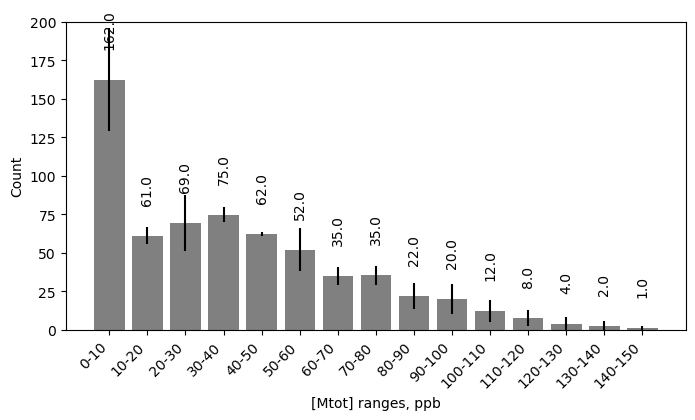

In [15]:
##OTHER PLOT

binsize = 10

bin_edges_rep1 = np.arange(0, 160, binsize)
df['bin_rep1'] = pd.cut(df['Total_Metal_Replicate_1'], bins=bin_edges_rep1)
bin_counts_rep1 = df['bin_rep1'].value_counts(sort=False)

bin_edges_rep2 = np.arange(0, 160, binsize)
df['bin_rep2'] = pd.cut(df['Total_Metal_Replicate_2'], bins=bin_edges_rep2)
bin_counts_rep2 = df['bin_rep2'].value_counts(sort=False)

bin_edges_rep3 = np.arange(0, 160, binsize)
df['bin_rep3'] = pd.cut(df['Total_Metal_Replicate_3'], bins=bin_edges_rep2)
bin_counts_rep3 = df['bin_rep3'].value_counts(sort=False)

bin_labels = [f"{int(left)}-{int(right)}" for left, right in zip(bin_edges_rep1[:-1], bin_edges_rep1[1:])]

z = np.vstack([bin_counts_rep1.to_numpy(), bin_counts_rep2.to_numpy(), bin_counts_rep2.to_numpy()])
avg, std = np.mean(z, axis=0), np.std(z, axis=0)

plt.figure(figsize=(8, 4))
plt.ylim(bottom=0, top=200)
bars = plt.bar(bin_labels, avg, yerr=std, color='grey')
for bar, label in zip(bars, avg):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() +20, round(label, 0),
             ha='center', va='bottom', rotation=90)
plt.xticks(rotation=45, ha="right")
plt.xlabel("[Mtot] ranges, ppb")
plt.ylabel("Count")
plt.savefig(f"12-10-2024, Frequency Count for Mtot Bins.svg", format="svg")
plt.show();

## Frequency Count for Mtot Subsets

C:\Users\diep5\AppData\Local\Temp\ipykernel_13204\1640200646.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[category_of_interest].fillna('unspecified', inplace=True)


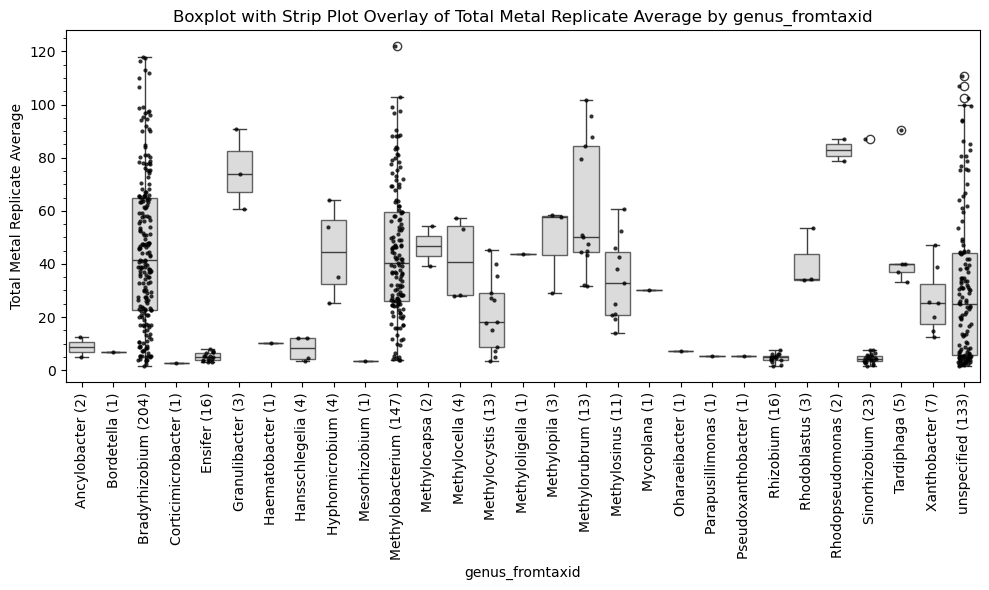

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

category_of_interest = 'genus_fromtaxid'

# Replace NaNs with a placeholder to treat them as a category
df[category_of_interest].fillna('unspecified', inplace=True)

# Calculate the counts for each category
category_counts = df[category_of_interest].value_counts()

# Get the unique categories, sorted alphabetically, and append the counts to the labels
ordered_categories = sorted(category_counts.index)
ordered_categories_with_counts = [f'{cat} ({category_counts[cat]})' for cat in ordered_categories]

# Map the original 'genus_fromtaxid' column to include counts in the labels
df[f'{category_of_interest}_with_counts'] = df[category_of_interest].map(lambda x: f'{x} ({category_counts[x]})')

# Set the size of the plot
plt.figure(figsize=(10, 6))

# Create a boxplot for the data with alphabetical order and counts in labels
sns.boxplot(x=f'{category_of_interest}_with_counts', y='Total_Metal_Replicate_Average', data=df,
            order=ordered_categories_with_counts,
            boxprops={'facecolor': 'lightgray', 'alpha': 0.8})

# Overlay a strip plot for individual data points with alphabetical order and counts in labels
sns.stripplot(x=f'{category_of_interest}_with_counts', y='Total_Metal_Replicate_Average', data=df,
              order=ordered_categories_with_counts,
              color='black', edgecolor='black', alpha=0.8, size=3,
              jitter=0.2)

# Add title and labels
plt.title(f'Boxplot with Strip Plot Overlay of Total Metal Replicate Average by {category_of_interest}')
plt.xlabel(category_of_interest)
plt.ylabel('Total Metal Replicate Average')

# Rotate x-axis labels if necessary (for readability)
plt.xticks(rotation=90)

# Minor ticks
plt.minorticks_on()  # Enable minor ticks
plt.tick_params(axis='x', which='minor', bottom=False)
plt.tick_params(axis='y', which='minor', direction='out', length=2, color='black')

# Show the plot
plt.tight_layout()
plt.savefig(f"12-10-2024, Box-strip-plot for {category_of_interest}.svg", format="svg")
plt.show()


### mGDH Analysis for Statistical Signficant Associations

In [26]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Dropping NaN values from the relevant columns
df_clean = df.dropna(subset=['mxaF', 'xoxF', 'exaF', 'mGDH', 'Total_Metal_Replicate_Average']).copy()

# Convert 'Y'/'N' to 1/0 for each gene using .loc
df_clean.loc[:, 'mxaF'] = df_clean['mxaF'].map({'Y': 1, 'N': 0})
df_clean.loc[:, 'xoxF'] = df_clean['xoxF'].map({'Y': 1, 'N': 0})
df_clean.loc[:, 'exaF'] = df_clean['exaF'].map({'Y': 1, 'N': 0})
df_clean.loc[:, 'mGDH'] = df_clean['mGDH'].map({'Y': 1, 'N': 0})

# Create a formula for the ANOVA model
formula = 'Total_Metal_Replicate_Average ~ mxaF + xoxF + exaF + mGDH'

# Fit the model
model = ols(formula, data=df_clean).fit()

# Perform ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)

# Display the results
print(anova_table)

from scipy import stats

# Perform one-way ANOVA for each gene
anova_mxaF = stats.f_oneway(df[df['mxaF'] == 'Y']['Total_Metal_Replicate_Average'], 
                            df[df['mxaF'] == 'N']['Total_Metal_Replicate_Average'])

anova_xoxF = stats.f_oneway(df[df['xoxF'] == 'Y']['Total_Metal_Replicate_Average'], 
                            df[df['xoxF'] == 'N']['Total_Metal_Replicate_Average'])

anova_exaF = stats.f_oneway(df[df['exaF'] == 'Y']['Total_Metal_Replicate_Average'], 
                            df[df['exaF'] == 'N']['Total_Metal_Replicate_Average'])

anova_mGDH = stats.f_oneway(df[df['mGDH'] == 'Y']['Total_Metal_Replicate_Average'], 
                            df[df['mGDH'] == 'N']['Total_Metal_Replicate_Average'])

print(f"\nANOVA results for mxaF: {anova_mxaF}")
print(f"ANOVA results for xoxF: {anova_xoxF}")
print(f"ANOVA results for exaF: {anova_exaF}")
print(f"ANOVA results for mGDH: {anova_mGDH}")

                 sum_sq     df          F        PR(>F)
mxaF         824.470644    1.0   1.189682  2.759659e-01
xoxF        4937.935682    1.0   7.125269  7.869906e-03
exaF       21109.812924    1.0  30.460722  5.706354e-08
mGDH        3720.842330    1.0   5.369045  2.093638e-02
Residual  318095.024989  459.0        NaN           NaN

ANOVA results for mxaF: F_onewayResult(statistic=5.423970648698101, pvalue=0.020292537486386805)
ANOVA results for xoxF: F_onewayResult(statistic=30.517691623168417, pvalue=5.5335185149151313e-08)
ANOVA results for exaF: F_onewayResult(statistic=45.870522029615564, pvalue=3.853723418095127e-11)
ANOVA results for mGDH: F_onewayResult(statistic=8.975791365673654, pvalue=0.002882937262150714)


## Taxonomic Breakdown

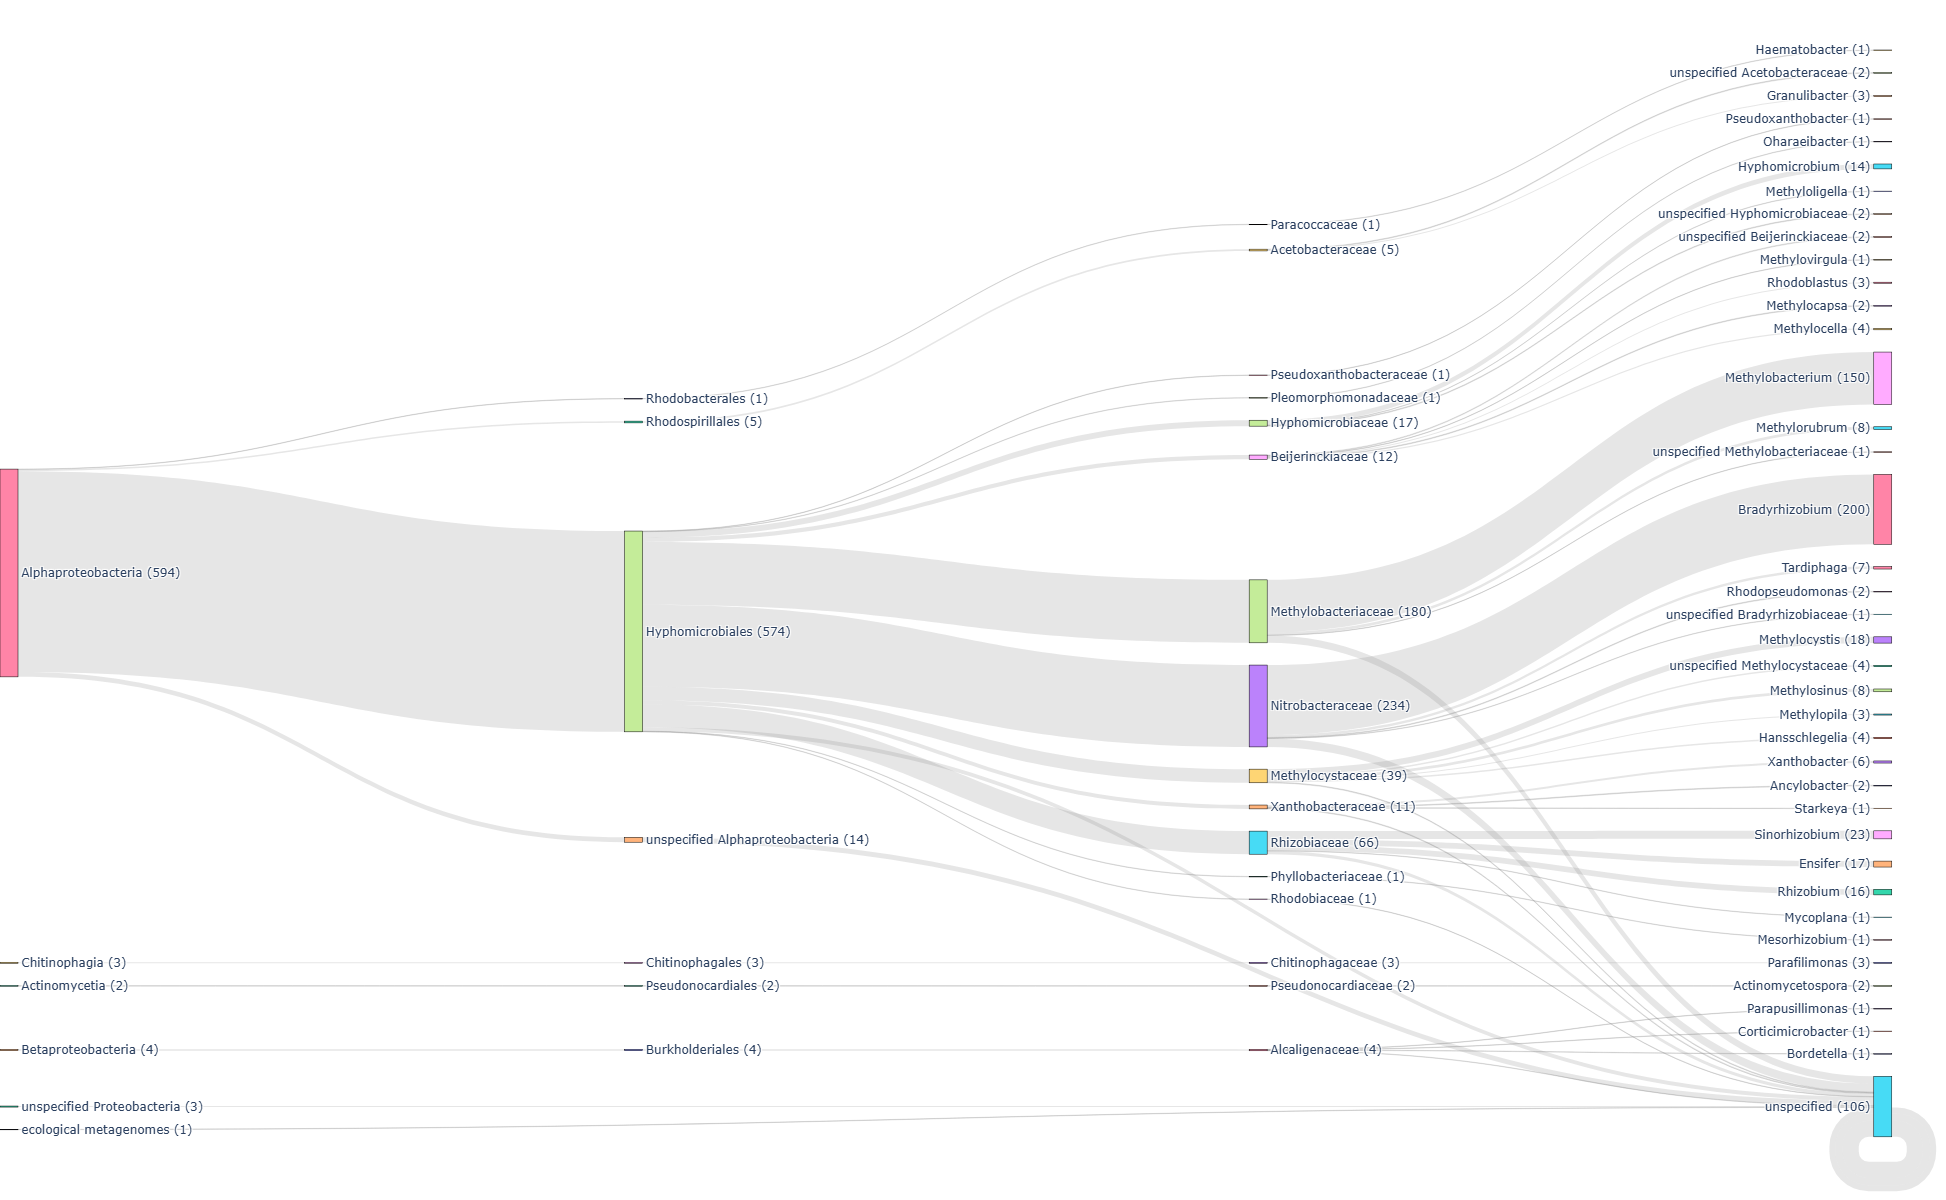

And there's 133 beloning to unclassified


In [30]:
# Step 1: Prepare the data
sources = []
targets = []
values = []

# taxonomic_levels = ['class_fromtaxid', 'order_fromtaxid', 'family_fromtaxid', 'genus_fromtaxid']
taxonomic_levels = ['class_original', 'order_original', 'family_original', 'genus_original']

for i in range(len(taxonomic_levels) - 1):
    source = df[taxonomic_levels[i]]
    target = df[taxonomic_levels[i + 1]]
    
    # Calculate the flow counts
    flow_counts = df.groupby([taxonomic_levels[i], taxonomic_levels[i + 1]]).size().reset_index(name='count')
    
    sources.extend(flow_counts[taxonomic_levels[i]])
    targets.extend(flow_counts[taxonomic_levels[i + 1]])
    values.extend(flow_counts['count'])

# Create a list of all unique nodes (taxonomic categories)
nodes = list(set(sources + targets))

# Map the categories to integers (for plotly)
source_indices = [nodes.index(source) for source in sources]
target_indices = [nodes.index(target) for target in targets]

# Aggregate counts for nodes
node_counts = df.groupby(taxonomic_levels[0]).size().to_dict()
for level in taxonomic_levels[1:]:
    node_counts.update(df.groupby(level).size().to_dict())

# Generate labels with counts for nodes
node_labels = [f'{node} ({node_counts.get(node, 0)})' for node in nodes]

# Step 2: Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=18,
        line=dict(color="black", width=0.5),
        label=node_labels,  # Updated labels with counts
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values,
        color='rgba(128, 128, 128, 0.2)',
    )
)])

fig.update_layout(
    font_size=12,
    height=1200,  # Increase height for better vertical spacing
    width=1000,    # Adjust width if needed
    margin=dict(l=0, r=0, t=50, b=10)  # Adjust margins as needed
)

fig.show()
# fig.write_image('test.svg', format = 'svg', engine = 'kaleido')

print("And there's 133 beloning to unclassified")

## DATA PROCESSING STEP 2 (df_logD_avg)

In [10]:
neutral_REE_header = ["Y", "La", "Ce", "Pr", "Nd", "Sm", "Eu", "Gd", "Tb", "Dy", "Ho", "Er", "Tm", "Yb", "Lu"]

def process_and_normalize_replicate(df, df_stocks, replicate_number):
    df_raw = df.loc[:, f'Y-{replicate_number}':f'Lu-{replicate_number}']
    df_raw.columns = neutral_REE_header
    df_logD = np.log10(df_stocks.iloc[replicate_number-1] / (df_stocks.iloc[replicate_number-1] - df_raw))
    
    # Handle NaN and infinity values
    df_logD = df_logD.replace([np.inf, -np.inf], np.nan)
    
    df_logD[f'max_value_{replicate_number}'] = df_logD.max(axis=1)
    df_normalized = df_logD.iloc[:, :15].div(df_logD[f'max_value_{replicate_number}'], axis=0)
    return df_normalized

def process_replicate(df, df_stocks, replicate_number):
    df_raw = df.loc[:, f'Y-{replicate_number}':f'Lu-{replicate_number}']
    df_raw.columns = neutral_REE_header
    df_logD = np.log10(df_stocks.iloc[replicate_number-1] / (df_stocks.iloc[replicate_number-1] - df_raw))
    
    # Handle NaN and infinity values
    df_logD = df_logD.replace([np.inf, -np.inf], np.nan)
    return df_logD

# Store DataFrames in a list
norm_logD_dataframes = []
logD_dataframes = []

# Process each replicate using a loop
for replicate_number in range(1, 4):
    df_logD = process_and_normalize_replicate(df, df_stocks, replicate_number)
    norm_logD_dataframes.append(df_logD)

for replicate_number in range(1, 4):
    df_logD = process_replicate(df, df_stocks, replicate_number)
    logD_dataframes.append(df_logD)

# Access the DataFrames from the list
df_logD_1 = norm_logD_dataframes[0] if len(norm_logD_dataframes) > 0 else pd.DataFrame()
df_logD_2 = norm_logD_dataframes[1] if len(norm_logD_dataframes) > 1 else pd.DataFrame()
df_logD_3 = norm_logD_dataframes[2] if len(norm_logD_dataframes) > 2 else pd.DataFrame()

df_logD_1_noNorm = logD_dataframes[0] if len(logD_dataframes) > 0 else pd.DataFrame()
df_logD_2_noNorm = logD_dataframes[1] if len(logD_dataframes) > 1 else pd.DataFrame()
df_logD_3_noNorm = logD_dataframes[2] if len(logD_dataframes) > 2 else pd.DataFrame()

# Concatenate the DataFrames along a new axis (axis=2) to form a 3D array
# Use only available DataFrames
data_to_stack = [df_logD_1.values, df_logD_2.values, df_logD_3.values]
stacked_data = np.stack(data_to_stack, axis=2)

# Calculate averages and standard deviations
df_logD_avg = np.mean(stacked_data, axis=2)
df_logD_avg = pd.DataFrame(df_logD_avg, columns=neutral_REE_header)

df_logD_std = np.std(stacked_data, axis=2)
df_logD_std = pd.DataFrame(df_logD_std, columns=neutral_REE_header)

# Add the three logD dataframes to the original dataframe df
df = pd.concat([df, df_logD_1_noNorm, df_logD_2_noNorm, df_logD_3_noNorm, 
                df_logD_1, df_logD_2, df_logD_3,
                df_logD_avg, df_logD_std], axis=1)

# Export the three logD dataframes to CSV files
df.to_csv('08-28-2024_updated_master_sheet_test1.csv', index=False)

## Single Ortholog Plotting Function for Selectivity Curves (logD)

In [11]:
def scatterplot_with_average(df_row1, yerr, df_row2, avg_row, title, 
                             xlabel, ylabel, hline=None, ax=None, show_REE_label=None, sample_std_shade=False, saveFig = False):
    if ax is None:
        plt.figure(figsize=(3, 3), dpi=150)
        plt.subplots_adjust(hspace=5)
        ax = plt.gca()

    avg_values = avg_row.mean(axis=0)
    std_values = avg_row.std(axis=0)
        
    # Plot the first row
    ax.scatter(neutral_REE_header, df_row1, label='Row 1', color='pink', s=15)
    if not sample_std_shade:
        ax.errorbar(neutral_REE_header, df_row1, yerr=yerr, color='pink', ecolor='pink', linestyle='--')
    else:
        ax.fill_between(neutral_REE_header, df_row1 - yerr, df_row1 + yerr,
                        color='pink', alpha=0.3, label='Error ± 1 SD')
        ax.plot(neutral_REE_header, df_row1, label='Row 2', color='pink', linestyle='--')

    # Plot the second row as a grey dotted line
    ax.scatter(neutral_REE_header, df_row2, label='Row 2', color='grey', s=15)
    ax.plot(neutral_REE_header, df_row2, label='Row 2', color='grey', linestyle='--')

    ax.fill_between(neutral_REE_header, avg_values - std_values, avg_values + std_values,
                        color='gray', alpha=0.3, label='Average ± 1 SD')


    # Add x-values next to the second scatter point
    if show_REE_label is not None:
        for i, txt in enumerate(neutral_REE_header):
            ax.annotate(txt, (neutral_REE_header[i], df_row1.iloc[i]),
                        textcoords="offset points", xytext=(0, -10), ha='center', fontsize=7)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_xticklabels([], rotation=45, ha="center")
    ax.set_ylim(-0.05, 1.05)

    # Add a horizontal line if specified
    if hline is not None:
        ax.axhline(y=hline, color='black', linestyle='--', label='Horizontal Line')

    # Move x-label to the top
    ax.xaxis.set_label_position('top')

    # Add legend
#     ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if saveFig is True:
        plt.savefig(f"{title}.svg", format="svg")

    if ax is None:
        plt.show();
        
        

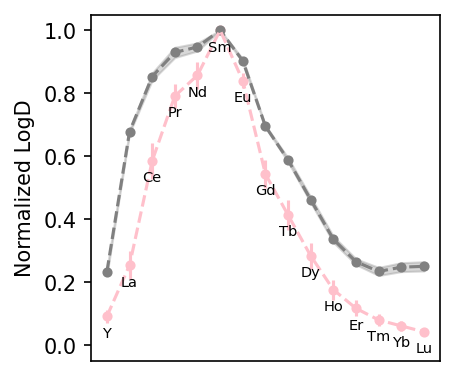

In [26]:
ortholog_IDs = [79]

for i in ortholog_IDs:
    scatterplot_with_average(df_logD_avg.iloc[i], df_logD_std.iloc[i], 
                         np.mean(df_logD_avg.iloc[MexLanM1:MexLanM3], axis=0), df_logD_avg.iloc[MexLanM1:MexLanM3], 
                         title = None, xlabel = None, ylabel="Normalized LogD", 
                         show_REE_label = True, sample_std_shade=False)

## DATA PROCESSING STEP 3 (df_logD_avg_cleaned)

In [14]:
# Assuming df is your DataFrame
num_rows_with_nan = df_logD_std.isna().any(axis=1).sum()
print("Number of rows with NaN values:", num_rows_with_nan)

Number of rows with NaN values: 5


In [15]:
rows_with_nan_indices1 = df_logD_avg[df_logD_avg.isna().any(axis=1)].index
rows_with_nan_indices2 = df_logD_std[df_logD_std.isna().any(axis=1)].index
print(rows_with_nan_indices1)
print(rows_with_nan_indices2)
print(rows_with_nan_indices1 == rows_with_nan_indices2)

Index([371, 425, 432, 544, 595], dtype='int64')
Index([371, 425, 432, 544, 595], dtype='int64')
[ True  True  True  True  True]


In [16]:
df_cleaned = df.drop(index=rows_with_nan_indices1)
# df_cleaned.to_csv('02-08-2024_updated_master_sheet_test2.csv', index=False)
df_logD_avg_cleaned = df_logD_avg.dropna()
df_logD_std_cleaned = df_logD_std.dropna()
# df_logD_avg_cleaned.to_csv('02-08-2024_df_logD_avg_cleaned.csv', index=False)

## Testing Different Clustering Algorithms

In [ ]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
import numpy as np
import matplotlib.pyplot as plt

def plot_umap_with_clustering(ax, umap_result, clustering_algorithm, cluster_name):
    plot = ax.scatter(umap_result[:, 0], umap_result[:, 1], c=clustering_algorithm, cmap='tab20b', s=8)

    # Plot contour lines for each cluster
    for cluster in np.unique(clustering_algorithm):
        if cluster == -1:  # Skip noise points for DBSCAN
            continue
        cluster_data = umap_result[clustering_algorithm == cluster]
        kde = KernelDensity(bandwidth=0.2)
        kde.fit(cluster_data)
        xx, yy = np.meshgrid(np.linspace(-3,14, 200),
                         np.linspace(-2,11, 200))
        zz = np.exp(kde.score_samples(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
        ax.contour(xx, yy, zz, colors='k', linewidths=0.25)
        
        # Add label for each cluster
        centroid = np.mean(cluster_data, axis=0)
        # Define offset for the label position
        ax.text(centroid[0], centroid[1], str(cluster), fontsize=10, color='black', weight = 'bold')

    ax.set_title(f'UMAP Result with {cluster_name} Clustering')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')

    return plot

# Assuming df_logD_avg is your DataFrame with shape (96, 15)
n_components = 2
random_state = 21

# Perform Standard Scaling
scaled_data = StandardScaler().fit_transform(df_logD_avg_cleaned.iloc[:, :15])

# Apply UMAP
umap = UMAP(n_components=n_components, random_state=random_state)
umap_result = umap.fit_transform(scaled_data)

# Apply different clustering algorithms
n_clusters = 8  # Number of clusters
agglomerative = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward', affinity='euclidean')
agglomerative_result = agglomerative.fit_predict(scaled_data)

kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
kmeans_result = kmeans.fit_predict(scaled_data)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_result = dbscan.fit_predict(scaled_data)

gmm = GaussianMixture(n_components=n_clusters, random_state=random_state)
gmm_result = gmm.fit_predict(scaled_data)

# Plot UMAP with different clustering algorithms in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(15, 15))

plot_umap_with_clustering(axs[0, 0], umap_result, agglomerative_result, "Agglomerative")
plot_umap_with_clustering(axs[0, 1], umap_result, kmeans_result, "KMeans")
plot_umap_with_clustering(axs[1, 0], umap_result, dbscan_result, "DBSCAN")
plot_umap_with_clustering(axs[1, 1], umap_result, gmm_result, "GaussianMixture")

# # Add a legend to the plot
# fig.legend(*plot.legend_elements(), title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.tight_layout()
plt.show()


## Testing Different Parameters for UMAP Dimensionality Reduction

In [ ]:
import matplotlib.pyplot as plt
from umap import UMAP
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Assuming df_logD_avg is your DataFrame with shape (96, 15)
n_components = 2
n_clusters = 8  # Number of clusters for KMeans Clustering
random_state = 21

# Define ranges for n_neighbors and min_dist
n_neighbors_range = [5, 10, 15, 50]
min_dist_range = [0.1, 0.2, 0.5, 1.0]

# Perform Standard Scaling
scaled_data = StandardScaler().fit_transform(df_logD_avg_cleaned.iloc[:, :15])

# Create a 4x4 grid of subplots
fig, axs = plt.subplots(4, 4, figsize=(20, 20))

for i, n_neighbors in enumerate(n_neighbors_range):
    for j, min_dist in enumerate(min_dist_range):
        # Apply UMAP
        umap = UMAP(n_components=n_components, random_state=random_state, min_dist=min_dist, n_neighbors=n_neighbors)
        umap_result = umap.fit_transform(scaled_data)
        
        # Apply KMeans Clustering with specified parameters
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        kmeans_result = kmeans.fit_predict(scaled_data)

        # Plot the UMAP result with colors based on KMeans Clustering labels
        axs[i, j].scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_result, cmap='tab20b', s=8)
        axs[i, j].set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        axs[i, j].set_xlim(umap_result[:, 0].min(), umap_result[:, 0].max())
        axs[i, j].set_ylim(umap_result[:, 1].min(), umap_result[:, 1].max())

# Add x-axis and y-axis titles for the full gridplot
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('UMAP Component 1', labelpad=20)
plt.ylabel('UMAP Component 2', labelpad=20)

plt.tight_layout()
plt.show()


## Testing Different Cluster Numbers 

C:\Users\diep5\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.

C:\Users\diep5\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\diep5\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.

C:\Users\diep5\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the env

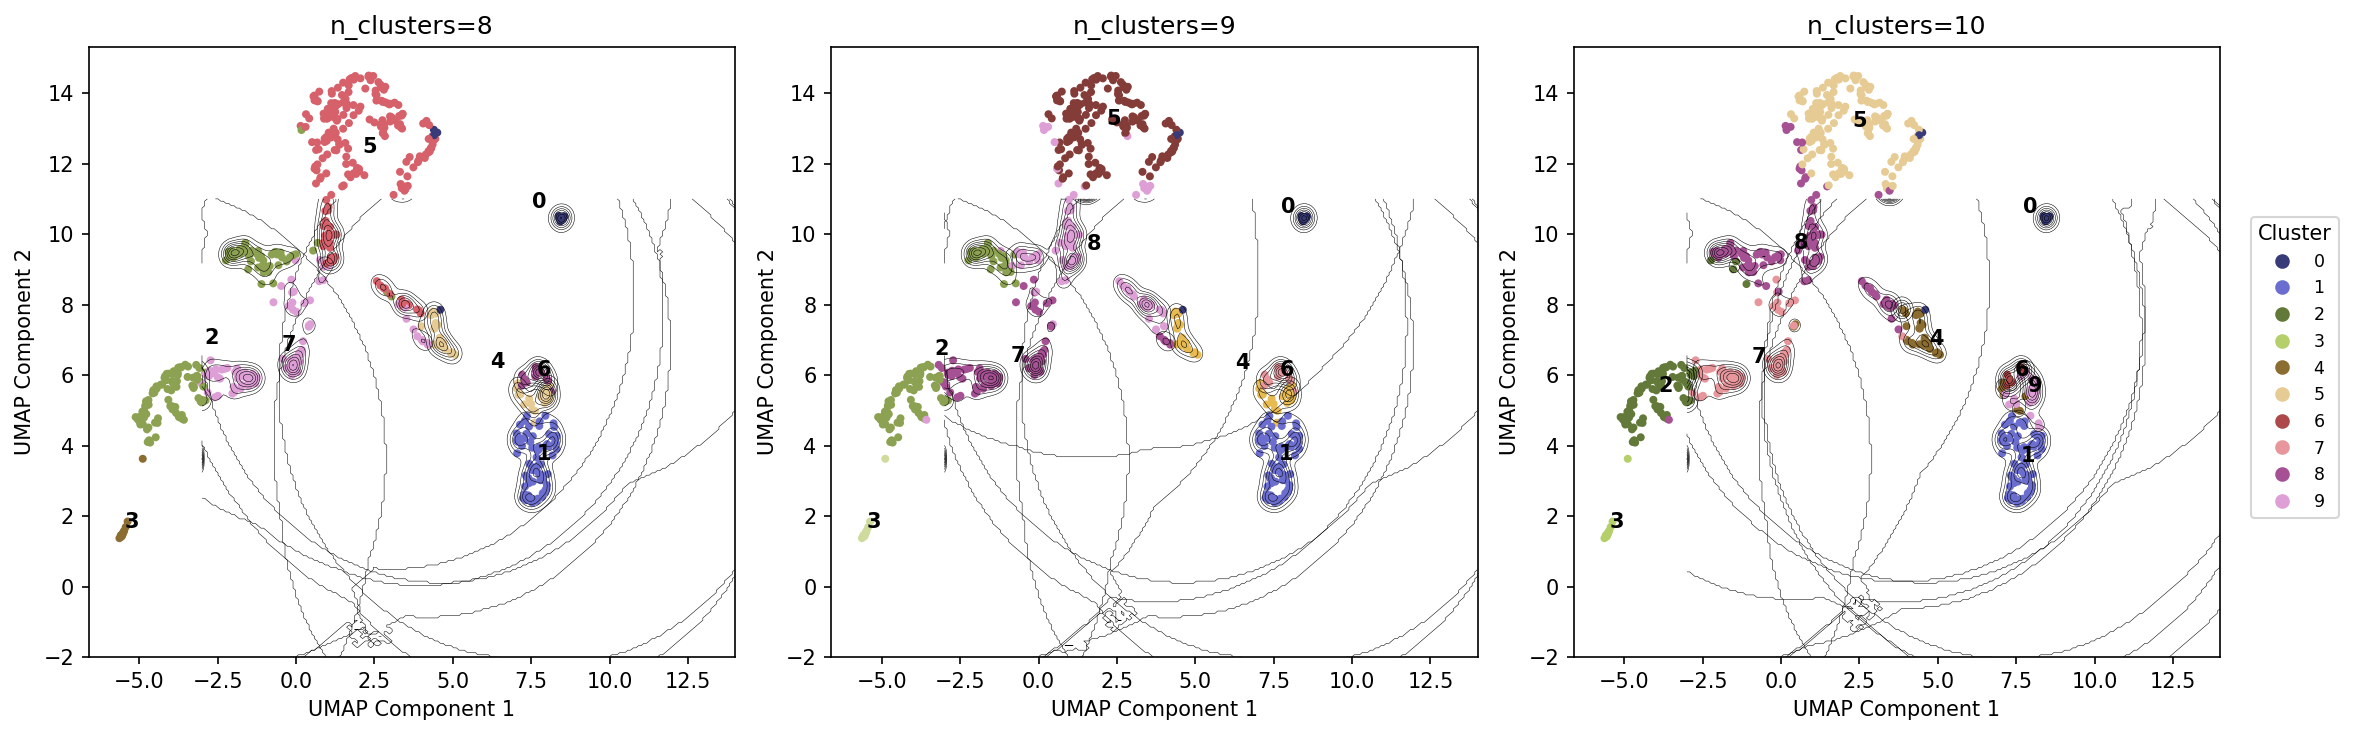

In [38]:
from sklearn.cluster import KMeans
from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity

# Assuming df_logD_avg is your DataFrame with shape (96, 15)
n_components = 2
random_state = 21
min_dist = 0.1
n_neighbors = 15

# Define the range of number of clusters
n_clusters_range = [8,9,10]

# Perform Standard Scaling
scaled_data = StandardScaler().fit_transform(df_logD_avg_cleaned.iloc[:, :15])

# Apply UMAP
umap = UMAP(n_components=n_components, random_state=random_state, min_dist=min_dist, n_neighbors=n_neighbors)
umap_result = umap.fit_transform(scaled_data)

# Create a 1x3 grid of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=150)

for i, n_clusters in enumerate(n_clusters_range):
    # Apply KMeans Clustering with specified parameters
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    kmeans_result = kmeans.fit_predict(scaled_data)

    # Plot the UMAP result with colors based on KMeans Clustering labels
    plot = axs[i].scatter(umap_result[:, 0], umap_result[:, 1], c=kmeans_result, cmap='tab20b', s=8)
    axs[i].set_title(f'n_clusters={n_clusters}')
    axs[i].set_xlabel('UMAP Component 1')
    axs[i].set_ylabel('UMAP Component 2')

    # Plot contour lines for each cluster
    # Compute the KDE for each cluster
    kdes = []
    for cluster in range(n_clusters):
        kde = KernelDensity(bandwidth=0.2)
        cluster_data = umap_result[kmeans_result == cluster]
        kde.fit(cluster_data)
        kdes.append(kde)

        # Plot contour lines for each cluster
        xx, yy = np.meshgrid(np.linspace(-3, 14, 200),
                             np.linspace(-2, 11, 200))
        zz = np.exp(kde.score_samples(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
        axs[i].contour(xx, yy, zz, colors='k', linewidths=0.25)
        
        # Add label for each cluster
        centroid = np.mean(cluster_data, axis=0)
        # Define offset for the label position
        axs[i].text(centroid[0], centroid[1], str(cluster), fontsize=10, color='black', weight='bold')

# Add a legend to the plot
fig.legend(*plot.legend_elements(), title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5), fontsize='small')

plt.tight_layout()
plt.show()


## Contour Plot for UMAP-Agglomerative Clustering

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from umap import UMAP
import pandas as pd
import matplotlib.pyplot as plt

# Assuming df_logD_avg is your DataFrame with shape (96, 15)
n_components = 2
n_clusters = 8  # Number of clusters for KMeans Clustering
random_state = 42
min_dist = 0.25
n_neighbors = 15

# Perform Standard Scaling
scaled_data = StandardScaler().fit_transform(df_logD_avg_cleaned.iloc[:, :15])

# Apply UMAP
umap = UMAP(n_components=n_components, random_state=random_state, min_dist=min_dist, n_neighbors=n_neighbors)
umap_result = umap.fit_transform(scaled_data)

# Apply Agglomerative Clustering with specified parameters
linkage = 'ward'  # Linkage criterion for Agglomerative Clustering
metric= 'euclidean'  # Affinity metric for Agglomerative Clustering

# Apply KMeans Clustering with specified parameters
agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
agglomerative_result = agglomerative.fit_predict(scaled_data)

# SAVE THE DATA
df_cleaned_reset = df_cleaned.reset_index(drop=True)
umap_result_reset = pd.DataFrame(umap_result).reset_index(drop=True)

df_cleaned_umap_result = pd.concat([df_cleaned_reset, 
                                   pd.DataFrame(agglomerative_result, columns=['agglomerative_cluster']), 
                                   pd.DataFrame(umap_result, columns=['UMAP-Component1', 'UMAP-Component2'])], 
                                  axis=1)
#df_cleaned_umap_result.to_csv('08-30-2024_updated_master_sheet_test3.csv', index=False)
#df_cleaned_umap_result = pd.read_csv('08-30-2024_updated_master_sheet_test3 (for R).csv')

C:\Users\diep5\AppData\Local\anaconda3\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [63]:
print(df_cleaned_umap_result.head(5))

  ID-1  ID-2 ID-3   ID-4      ID-5  ID-6     ID-7  ID-8  \
0   e4    94   A1  e4-A1  e4-A1-A1     0  e4-0-A1     0   
1   e4    95   A2  e4-A2  e4-A2-A2     1  e4-1-A2     0   
2   e4    96   A3  e4-A3  e4-A3-A3     2  e4-2-A3     0   
3   e4    97   A4  e4-A4  e4-A4-A4     3  e4-3-A4     0   
4   e4    98   A5  e4-A5  e4-A5-A5     4  e4-4-A5     0   

                                      nodeacc1        nodeacc2  ...      Tb.7  \
0      >WP_216758941.1 [Rhizobium sp. WYJ-E13]  WP_216758941.1  ...  0.105988   
1           >RUP13001.1 [Methylobacterium sp.]      RUP13001.1  ...  0.130230   
2  >WP_103121657.1 [Methylopila sp. Yamaguchi]  WP_103121657.1  ...  0.056787   
3    >WP_084563696.1 [Pseudoxanthobacter soli]  WP_084563696.1  ...  0.047626   
4       >WP_020181142.1 [Methylopila sp. M107]  WP_020181142.1  ...  0.047589   

       Dy.7      Ho.7      Er.7      Tm.7      Yb.7      Lu.7  \
0  0.109862  0.122999  0.109028  0.119921  0.041190  0.044910   
1  0.142418  0.140185  0.122

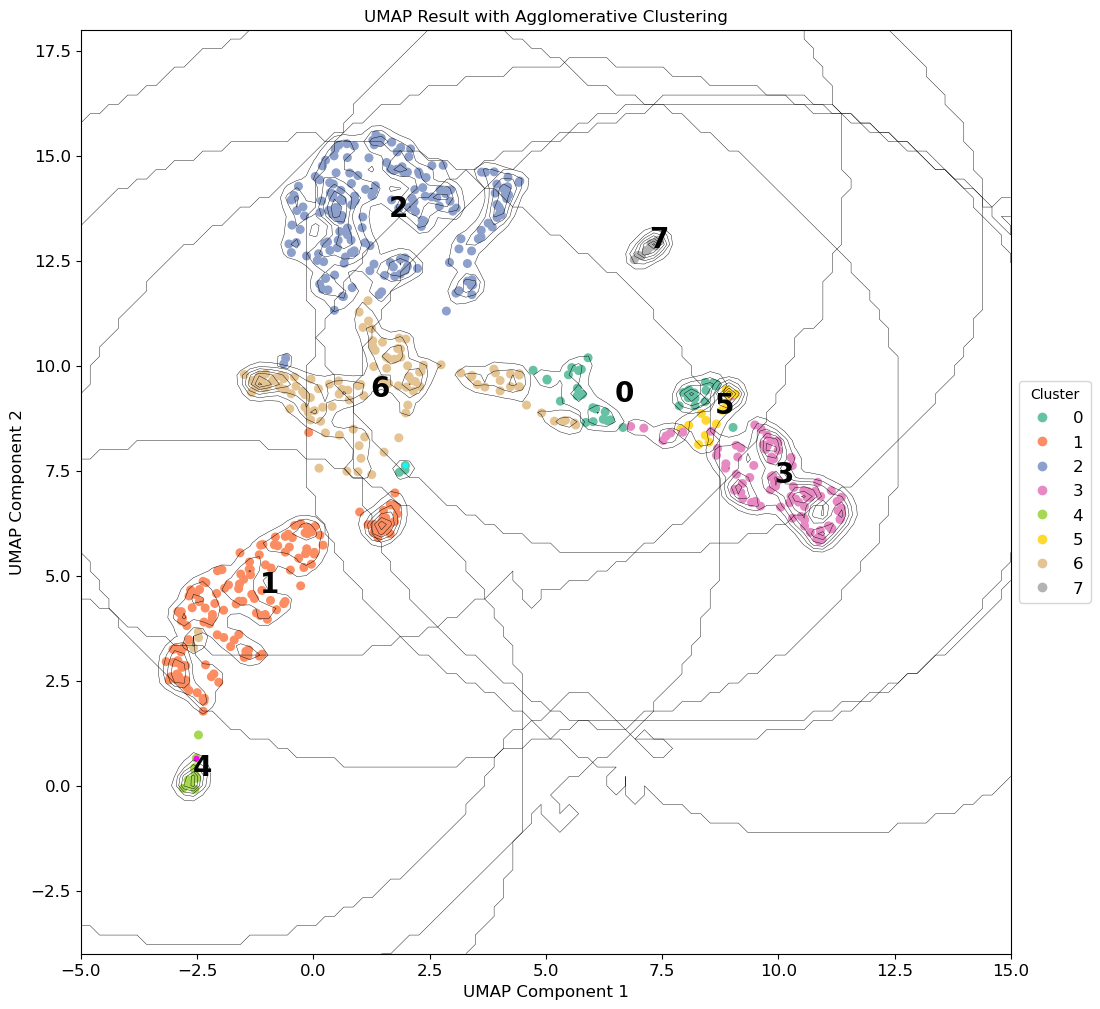

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import KernelDensity

# Plot the UMAP result with colors based on KMeans Clustering labels
plt.figure(figsize=(12, 12))
plot = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=agglomerative_result, cmap='Set2', s=30)

# Plot scatter points for specific positions (with fixed sizes)
plt.scatter(umap_result[180, 0], umap_result[180, 1], c="magenta", s=10)
plt.scatter(umap_result[622-5, 0], umap_result[622-5, 1], c="cyan", s=10)

# Plot contour lines for each cluster
kdes = []
for cluster in range(n_clusters):
    kde = KernelDensity(bandwidth=0.18)
    cluster_data = umap_result[agglomerative_result == cluster]
    kde.fit(cluster_data)
    kdes.append(kde)

    xx, yy = np.meshgrid(np.linspace(-5, 15, 100),
                         np.linspace(-4, 18, 100))
    zz = np.exp(kde.score_samples(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.contour(xx, yy, zz, colors='k', linewidths=0.3)

    # Add label for each cluster
    centroid = np.mean(cluster_data, axis=0)
    plt.text(centroid[0], centroid[1], str(cluster), fontsize=20, color='black', weight='bold')

plt.title('UMAP Result with Agglomerative Clustering', fontsize=12)
plt.xlabel('UMAP Component 1', fontsize=12)
plt.ylabel('UMAP Component 2', fontsize=12)

# Increase font size of tick labels
plt.tick_params(axis='both', which='major', labelsize=12)

plt.legend(*plot.legend_elements(), title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
# plt.savefig("08-29-2024, Contour Plot for Selectivity Clusters (ULTIMATE).svg", format='svg')
plt.show()


### Breakdown of Clusters According to Category of Interest

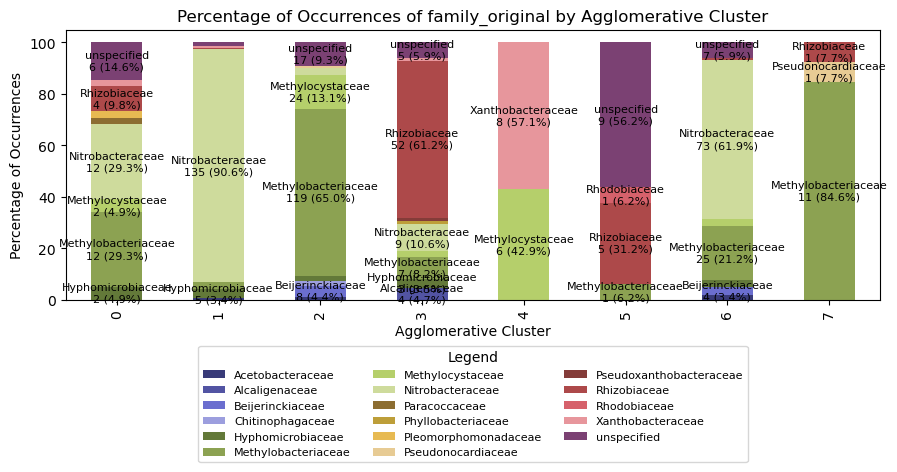

                 Family  Cluster                            Genus  Count
0   Methylobacteriaceae        0                 Methylobacterium      6
1   Methylobacteriaceae        0                      unspecified      5
2   Methylobacteriaceae        0                    Methylorubrum      1
3   Methylobacteriaceae        2                 Methylobacterium    101
4   Methylobacteriaceae        2                      unspecified     12
5   Methylobacteriaceae        2                    Methylorubrum      5
6   Methylobacteriaceae        2  unspecified Methylobacteriaceae      1
7   Methylobacteriaceae        6                 Methylobacterium     20
8   Methylobacteriaceae        6                      unspecified      3
9   Methylobacteriaceae        6                    Methylorubrum      2
10  Methylobacteriaceae        7                 Methylobacterium     11
11     Nitrobacteraceae        0                   Bradyrhizobium     12
12     Nitrobacteraceae        1                   

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

category_of_interest = 'family_original'
subcategory_of_interest = 'genus_original'
percentage_threshold = 20  # Threshold for considering significant families

# Define the custom colors
custom_colors = plt.cm.tab20b.colors[:num_categories]

# Group by 'agglomerative_cluster' and 'family_original', then count occurrences
grouped = df_cleaned_umap_result.groupby(['agglomerative_cluster', category_of_interest]).size().reset_index(name='count')

# Pivot the table to have clusters as rows and families as columns
pivot_table = grouped.pivot(index='agglomerative_cluster', columns=category_of_interest, values='count').fillna(0)

# Normalize the data: convert counts to proportions
pivot_table_normalized = pivot_table.div(pivot_table.sum(axis=1), axis=0) * 100  # Converts to percentages

# Plot the normalized data with custom colors
ax = pivot_table_normalized.plot(kind='bar', stacked=True, figsize=(9, 5), color=custom_colors)

plt.title(f'Percentage of Occurrences of {category_of_interest} by Agglomerative Cluster')
plt.xlabel('Agglomerative Cluster')
plt.ylabel('Percentage of Occurrences')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, title="Legend", fontsize = 8)
plt.tight_layout()

# Annotate the bars with the family name, absolute values, and percentages
for i, container in enumerate(ax.containers):
    # Retrieve absolute values from the original pivot_table
    absolute_values = pivot_table.iloc[:, i].values
    # Retrieve percentages from the normalized pivot_table
    percentages = pivot_table_normalized.iloc[:, i].values
    # Get the family names
    family_names = pivot_table.columns[i]
    
    # Combine family names, absolute values, and percentages into the label
    labels = [f'{family_names}\n{int(val)} ({pct:.1f}%)' if pct > 3 else '' for val, pct in zip(absolute_values, percentages)]
    
    # Add the labels to the plot
    ax.bar_label(container, labels=labels, label_type='center', fontsize=8)

# Save and show the plot
plt.savefig("08-30-2024, family_composition (ULTIMATE).svg", format="svg")
plt.show()

# Analyze significant families
significant_family_data = {}

for cluster in pivot_table.index:
    # Get families that make up more than 20% in the current cluster
    significant_families = pivot_table_normalized.loc[cluster]
    significant_families = significant_families[significant_families > percentage_threshold]
    
    for family in significant_families.index:
        # Filter the data for the current family and cluster
        family_data = df_cleaned_umap_result[(df_cleaned_umap_result[category_of_interest] == family) & (df_cleaned_umap_result['agglomerative_cluster'] == cluster)]
        
        # Get the organism names and count their occurrences
        organism_counts = family_data['genus_original'].value_counts()
        
        if family not in significant_family_data:
            significant_family_data[family] = {}
        
        significant_family_data[family][cluster] = organism_counts
        
# Convert the significant_family_data dictionary to a DataFrame
rows = []
for family, clusters in significant_family_data.items():
    for cluster, counts in clusters.items():
        for organism, count in counts.items():
            rows.append({
                'Family': family,
                'Cluster': cluster,
                'Genus': organism,
                'Count': count
            })

# Create DataFrame from rows
significant_family_df = pd.DataFrame(rows)

# Print the DataFrame
print(significant_family_df)

# Optionally, save the DataFrame to a CSV file
# significant_family_df.to_csv("08-30-2024, significant_family_data (ULTIMATE).csv", index=False)


In [ ]:
import matplotlib.pyplot as plt

# Define a function to format the labels with both percentage and absolute numbers
def func(pct, allvals):
    total = sum(allvals)
    absolute = int(round(pct / 100. * total))
    return f'n={absolute} ({pct:.1f}%)'

# Get a unique list of genera
unique_genera = significant_family_df['Genus'].unique()

# Define a color palette from Set3 for the number of unique genera
color_palette = plt.cm.tab20c.colors[:len(unique_genera)]

# Create a dictionary to map genera to colors
color_map = dict(zip(unique_genera, color_palette))

# Define the size of the pie charts
figsize = (3, 3)  # Width and height in inches

# Iterate over each cluster in the DataFrame
for cluster in significant_family_df['Cluster'].unique():
    # Filter data for the current cluster
    cluster_data = significant_family_df[significant_family_df['Cluster'] == cluster]
    
    # Group by Family and sum counts of genera
    family_data = cluster_data.groupby('Family').agg({'Count': 'sum'}).reset_index()
    
    # For each family in the cluster, create a pie chart
    for _, family_row in family_data.iterrows():
        family = family_row['Family']
        family_counts = cluster_data[cluster_data['Family'] == family].set_index('Genus')['Count']
        
        # Plot pie chart with specified size
        fig, ax = plt.subplots(figsize=figsize)  # Set the size of the figure
        wedges, texts, autotexts = ax.pie(
            family_counts, 
            labels=family_counts.index, 
            autopct=lambda pct: func(pct, family_counts),  # Use custom function for labels
            startangle=90, 
            pctdistance=0.85, 
            labeldistance=1.4,  # Increased label distance from the center
            radius=0.5,  # Half the current size
            colors=[color_map[genus] for genus in family_counts.index]  # Apply consistent colors
        )
        
        # Draw circle in the center to make it look like a donut chart
        centre_circle = plt.Circle((0, 0), 0.26, fc='white')
        ax.add_artist(centre_circle)
        
        # Adjust labels and text
        for text in texts:
            text.set_size(8)  # Set text size
            text.set_fontstyle('italic')  # Italicize the genus names
        for autotext in autotexts:
            autotext.set_size(8)  # Set percentage size
        
        ax.set_title(f'{family} in Cluster {cluster}')
        
        # Save the pie chart
        plt.savefig(f'{family}_cluster_{cluster}.svg', format='svg')
        plt.show()


In [ ]:
def scatterplot_xy_withHue2(df, x_col, y_col, error_col, category_col, colour, title="Scatter Plot", xlabel="X-axis", ylabel="Y-axis", hline=None, errorbars=False, special_points=None, save = False, saveName = ''):
    size_mapping = (10, 50)  # This makes the datapoints bigger than their defaults
    plt.figure(figsize=(18, 2.3))
    
    # Scatter plot with size parameter for errors
    ax = sns.scatterplot(x=x_col, y=y_col, hue=category_col, palette=colour, size=error_col, sizes=size_mapping, data=df)
    
    if errorbars:
        plt.errorbar(x=df[x_col], y=df[y_col], yerr=df[error_col], fmt='none', ecolor='gray', elinewidth=0.5, capsize=0, barsabove = False)
        plt.ylim(0, 150)
    
    # Plot special points with specific colors
    if special_points:
        for point in special_points:
            plt.scatter(df.loc[point['index'], x_col], df.loc[point['index'], y_col], 
                        c=point['color'], s=point.get('size', 100), label=point.get('label', None))
    
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(-5, 630)
    
    # Major ticks
    plt.xticks(np.arange(0, 630, 50))
    plt.yticks(np.arange(0, 160, 25))
    
    # Minor ticks
    plt.minorticks_on()  # Enable minor ticks
    plt.tick_params(axis='x', which='minor', direction='out', length=2, color='black')
    plt.tick_params(axis='y', which='minor', direction='out', length=2, color='black')
       
    # Add horizontal line if specified
    if hline is not None:
        plt.axhline(y=hline, color='black', linestyle='--', label='Horizontal Line')
    
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3, title="Legend")
    
    if save:
        plt.savefig(saveName, format = 'svg')
    plt.show()


In [ ]:
# Sort the dataframe by cluster in descending order and then by Total_Metal_Replicate_Average in ascending order
df_sorted = df_cleaned_umap_result.sort_values(
    by=[category_of_interest1, 'Total_Metal_Replicate_Average'],
    ascending=[True,True]
)
# print(df_sorted)

category_of_interest1 = 'agglomerative_cluster'
which_palette_1 = "Set2"
count1 = df_sorted[category_of_interest1].nunique()

special_points = [
    {'index': 474-94, 'color': 'magenta', 'size': 12, 'label': 'Special Point 1'},
    {'index': 617, 'color': 'cyan', 'size': 12, 'label': 'Special Point 2'}
    # ,{'index': 130-94, 'color': 'red', 'size': 12, 'label': 'Special Point 2'}
]


# Call the updated function with the sorted dataframe
scatterplot_xy_withHue2(df_sorted, 
                       x_col="ID-4", 
                       y_col='Total_Metal_Replicate_Average', 
                       error_col='Total_Metal_Replicate_SD', 
                       category_col=category_of_interest1, 
                       colour=sns.color_palette(which_palette_1, count1), 
                       title="Average_Norm_Total_Metal_Rep", 
                       xlabel="Ortholog_ID", 
                       ylabel="Total Metal Captured (ppb)",
                       hline=7.5,
                       errorbars=True,
                       special_points=special_points,
                       save = False,
                       saveName = '08-29-2024, Total Metal per Ortholog Ordered for Selectivity Cluster (ULTIMATE).svg')

### Interactive Contour Plot for Data Exploration

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
import numpy as np
from sklearn.neighbors import KernelDensity

# Assuming 'df_cleaned_umap_result' is your DataFrame containing UMAP results, cluster labels, and 'ID-6'
df_cleaned_umap_result['UMAP_1'] = umap_result[:, 0]  # Add UMAP Component 1 to DataFrame
df_cleaned_umap_result['UMAP_2'] = umap_result[:, 1]  # Add UMAP Component 2 to DataFrame
df_cleaned_umap_result['Cluster'] = agglomerative_result  # Add cluster labels to DataFrame

# Create the scatter plot using Plotly Express
scatter_fig = px.scatter(
    df_cleaned_umap_result,
    x='UMAP_1',
    y='UMAP_2',
    color='Cluster',
    hover_data=['ID-6','family_original','genus_original','species_original'],  # Include 'ID-6' column in hover data
    title='UMAP Result with Agglomerative Clustering',
    labels={'UMAP_1': 'UMAP Component 1', 'UMAP_2': 'UMAP Component 2'}  # Label the axes
)

# Convert the Plotly Express figure to a graph object figure to add contours and labels
fig = go.Figure(data=scatter_fig.data)

# Add specific points (e.g., point at index 180 and 617)
fig.add_trace(go.Scatter(
    x=[umap_result[130-94, 0], umap_result[617, 0]],
    y=[umap_result[130-94, 1], umap_result[617, 1]],
    mode='markers',
    marker=dict(color=['magenta', 'cyan'], size=10),
    name='Specific Points',
    text=['ID-6: {}'.format(df_cleaned_umap_result.loc[180, 'ID-6']),
          'ID-6: {}'.format(df_cleaned_umap_result.loc[617, 'ID-6'])],
    hoverinfo='text'
))

# Add contour lines and labels for each cluster
for cluster in range(n_clusters):
    kde = KernelDensity(bandwidth=0.2)
    cluster_data = umap_result[agglomerative_result == cluster]
    kde.fit(cluster_data)

    # Create a grid over the UMAP space
    xx, yy = np.meshgrid(np.linspace(-3, 17, 100),
                         np.linspace(-5, 14, 100))
    zz = np.exp(kde.score_samples(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)

    # Add contour plot to the figure
    fig.add_trace(go.Contour(
        x=xx[0],
        y=yy[:, 0],
        z=zz,
        contours_coloring='lines',
        line_width=0.5,
        showscale=False,
        name=f'Contour {cluster}',
        hoverinfo='skip'  # Skip hover info for contours to preserve scatter hover text
    ))

    # Calculate the centroid of the cluster
    centroid = np.mean(cluster_data, axis=0)

    # Add a text label for the cluster at its centroid
    fig.add_trace(go.Scatter(
        x=[centroid[0]],
        y=[centroid[1]],
        mode='text',
        text=[str(cluster)],
        textfont=dict(size=24, color='black'),
        name=f'Label {cluster}',
        hoverinfo='skip'  # Skip hover info for labels
    ))

# Update layout for better visualization
fig.update_layout(
    width=1000,
    height=1000,
    legend_title='Cluster',
    hovermode='closest'  # Ensures the hover info prioritizes the nearest point
)
fig.write_html("umap_clustering.html")
# Show the figure
fig.show()


### Contour Plot for Color Mapping with Category of Interest

In [55]:
def plot_categorical_umap_kmeans(df_cleaned_umapresult, umap_result, agglomerative_result, 
                          category='bin_Replicate_1', colour='viridis', 
                          shrink=0.8, troubleshooting2=False, 
                                 filename = None):
    """
    Plot t-SNE result with colors based on a categorical column.

    Parameters:
        df_cleaned_umapresult (DataFrame): DataFrame containing the categorical column.
        umap_result (numpy array): t-SNE result.
        kmeans_result (numpy array): Result of KMeans Clustering.
        category (str): Name of the categorical column in df_cleaned_umapresult.
        colour (str): Colormap for coloring the plot.
        shrink (float): Shrinkage factor for the colorbar.
        troubleshooting2 (bool): If True, print out numerical label and corresponding categorical string pairs.
        n_clusters (int): Number of clusters for plotting contour lines.

    Returns:
        None
    """
    # Convert categorical values to numeric labels
    labels, unique = pd.factorize(df_cleaned_umapresult[category])
    cmap = plt.cm.get_cmap(colour, len(unique)-2)
    custom_cmap = plt.cm.colors.ListedColormap(cmap.colors)

    # Plot the t-SNE result with colors based on a categorical column
    plt.figure(figsize=(6.5, 5), dpi=150)
    plot = plt.scatter(umap_result[:, 0], umap_result[:, 1], c=labels, cmap=custom_cmap, s=8)

    if troubleshooting2:
        # Print out the mapping between numerical labels and categorical strings
        numerical_to_categorical = dict(zip(labels, df_cleaned_umapresult[category]))
        for numerical_label, categorical_string in numerical_to_categorical.items():
            print(f"{numerical_label}: {categorical_string}")

    # Demark positions
    plt.scatter(umap_result[180, 0], umap_result[180, 1], c="magenta", s=5)  
    plt.scatter(umap_result[622-5, 0], umap_result[622-5, 1], c="cyan", s=5)  

    # Plot contour lines for each cluster
    # Compute the KDE for each cluster
    kdes = []
    for cluster in range(n_clusters):
        kde = KernelDensity(bandwidth=0.2)
        cluster_data = umap_result[agglomerative_result == cluster]
        kde.fit(cluster_data)
        kdes.append(kde)

        # Plot contour lines for each cluster
        xx, yy = np.meshgrid(np.linspace(-3, 17, 100),
                         np.linspace(-5, 14, 100))
        zz = np.exp(kde.score_samples(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
        plt.contour(xx, yy, zz, colors='k', linewidths=0.25)

        # Add label for each cluster
        centroid = np.mean(cluster_data, axis=0)
        # Define offset for the label position
        plt.text(centroid[0], centroid[1], str(cluster), fontsize=10, color='black', weight='bold')

    cbar = plt.colorbar(plot, ticks=np.arange(len(unique)), shrink=shrink)  # Adjust shrink value as needed
    cbar.ax.set_yticks(np.arange(len(unique))-0.5)  # Center the ticks
    cbar.ax.set_yticklabels(unique, fontsize='small')  # Set fontsize to 'small'

    plt.title(f'UMAP Result with {filename} Clustering')
    plt.xlabel('UMAP Component 1')
    plt.ylabel('UMAP Component 2')
#     plt.savefig(f"UMAP_with_{filename}_Clustering_v1.svg", format = 'svg')
    plt.show();

C:\Users\diep5\AppData\Local\Temp\ipykernel_13204\4075451667.py:23: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



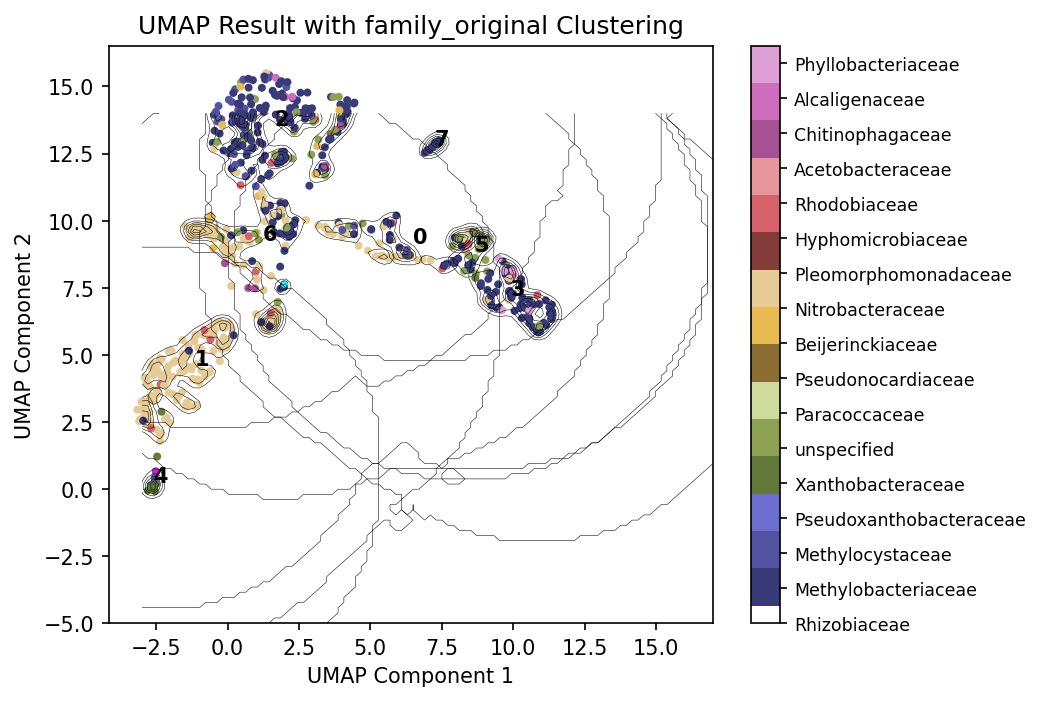

In [56]:
category_of_interest = 'family_original'
plot_categorical_umap_kmeans(df_cleaned_umap_result, umap_result, agglomerative_result, 
                      category=category_of_interest, colour='tab20b', 
                      shrink=1, troubleshooting2=False,
                            filename = category_of_interest)

### Silhouette Score

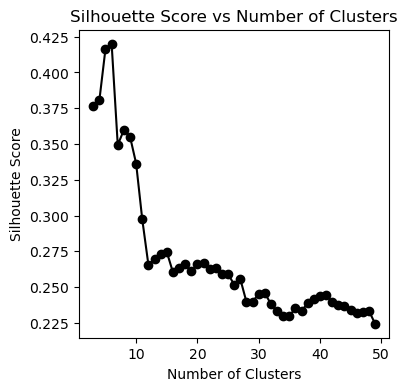

In [29]:
# List to store silhouette scores
silhouette_scores = []

# Range of cluster sizes
cluster_sizes = range(3, 50)

for n_clusters in cluster_sizes:
    # Apply Agglomerative Clustering with specified parameters
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_result = agglomerative_clustering.fit_predict(scaled_data)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(scaled_data, agglomerative_result)
    silhouette_scores.append(silhouette_avg)

# Plot silhouette scores
plt.figure(figsize=(4, 4))  # Make the plot a square
plt.plot(cluster_sizes, silhouette_scores, marker='o', color='black')  # Change the line color to black
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(False)  # Remove the grid lines
plt.savefig("12-12-2024, Silhouette Score for UMAP and Agglomerative Clustering.svg", format='svg')
plt.show()

## DATA PROCESSING STEP 4 (new dataframes for each cluster)

In [20]:
df_logD_avg_cleaned['Cluster_Labels'] = agglomerative_result
cluster_dfs_avg = []
n_clusters = 8
# Iterate over each cluster label
for label in range(n_clusters): 
    # Filter the dataframe based on the cluster label and drop the 'Cluster_Labels' column
    cluster_df = df_logD_avg_cleaned.loc[df_logD_avg_cleaned['Cluster_Labels'] == label].drop(columns=['Cluster_Labels'])
    # Reset the index to retain the original indices
    cluster_df.reset_index(drop=False, inplace=True)  # Set inplace=True to modify the dataframe in-place
    # Append the filtered dataframe to the list
    cluster_dfs_avg.append(cluster_df)

# Unpack the list of dataframes into individual variables
(df_logD_avg_cleaned_cluster0, df_logD_avg_cleaned_cluster1, df_logD_avg_cleaned_cluster2, 
df_logD_avg_cleaned_cluster3, df_logD_avg_cleaned_cluster4, df_logD_avg_cleaned_cluster5,
df_logD_avg_cleaned_cluster6, df_logD_avg_cleaned_cluster7) = cluster_dfs_avg


cluster_dfs_std = []

df_logD_std_cleaned['Cluster_Labels'] = df_logD_avg_cleaned['Cluster_Labels']

# Iterate over each cluster label
for label in range(n_clusters): 
    # Filter the dataframe based on the cluster label and drop the 'Cluster_Labels' column
    cluster_df = df_logD_std_cleaned.loc[df_logD_std_cleaned['Cluster_Labels'] == label].drop(columns=['Cluster_Labels'])
    # Reset the index to retain the original indices
    cluster_df.reset_index(drop=False, inplace=True)  # Set inplace=True to modify the dataframe in-place
    # Append the filtered dataframe to the list
    cluster_dfs_std.append(cluster_df)

# Unpack the list of dataframes into individual variables
(df_logD_std_cleaned_cluster0, df_logD_std_cleaned_cluster1, df_logD_std_cleaned_cluster2, 
df_logD_std_cleaned_cluster3, df_logD_std_cleaned_cluster4, df_logD_std_cleaned_cluster5,
df_logD_std_cleaned_cluster6, df_logD_std_cleaned_cluster7) = cluster_dfs_std

C:\Users\diep5\AppData\Local\Temp\ipykernel_4044\2526661760.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logD_avg_cleaned['Cluster_Labels'] = agglomerative_result
C:\Users\diep5\AppData\Local\Temp\ipykernel_4044\2526661760.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_logD_std_cleaned['Cluster_Labels'] = df_logD_avg_cleaned['Cluster_Labels']


### Compute Number of Members per Cluster

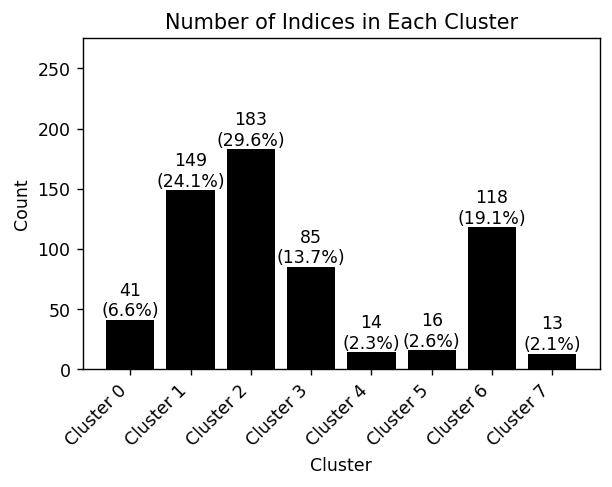

In [21]:
# Define a list to store indices for each cluster
cluster_indices = []

# Iterate over each cluster dataframe
for cluster_df in [df_logD_avg_cleaned_cluster0, df_logD_avg_cleaned_cluster1,
                   df_logD_avg_cleaned_cluster2, df_logD_avg_cleaned_cluster3,
                   df_logD_avg_cleaned_cluster4, df_logD_avg_cleaned_cluster5,
                   df_logD_avg_cleaned_cluster6, df_logD_avg_cleaned_cluster7]:
    # Extract indices from the current cluster dataframe
    indices = cluster_df['index'].tolist()
    # Append adjusted indices to the list
    cluster_indices.append(indices)

# Calculate the length of indices for each cluster and store in a dictionary
cluster_lengths = {f"Cluster {i}": len(indices) for i, indices in enumerate(cluster_indices)}

# Calculate the total number of indices across all clusters
total_count = sum(cluster_lengths.values())

# Create bar plot
plt.figure(figsize=(5, 4), dpi=125)
bars = plt.bar(cluster_lengths.keys(), cluster_lengths.values(), color='black')
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.ylim(bottom=0, top=275)
plt.title('Number of Indices in Each Cluster')
plt.xticks(rotation=45, ha='right')

# Add labels on top of each bar with the total count and percentage
for bar in bars:
    count = int(bar.get_height())
    percentage = (count / total_count) * 100
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{count}\n({percentage:.1f}%)', ha='center', va='bottom')

# Show plot
plt.tight_layout()
plt.show()

## Grid of Plots for each Cluster

In [22]:
def plot_clustered_logD_plots(cluster_of_interest, save = None, jupyter_display = False):

    # Assuming df_logD_1 is your DataFrame with shape (96, 15)
    num_rows, num_cols = math.ceil(len(cluster_indices[cluster_of_interest])/12), 12  # Define the grid shape

    # Increase the figure height to increase vertical spacing
    fig_height = 1.2 * num_rows

    # Create a 12x8 grid of subplots
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, fig_height), sharex=True, sharey=True)

    # Flatten the 2D array of subplots into a 1D array
    axs = axs.flatten()

    for i in tqdm(range(num_rows)):
        for j in range(num_cols):
            # Get the current cluster index based on the subplot position
            cluster_index = i * num_cols + j
            
            # Check if the current cluster index exceeds the number of clusters
            if cluster_index >= len(cluster_dfs_avg[cluster_of_interest]):
                # If yes, break out of the loop
                break
            
            # Extract the index number for the current dataframe in the cluster
            df_index = cluster_dfs_avg[cluster_of_interest].iloc[cluster_index,0]

            # Check if the current dataframe is empty
            if cluster_dfs_avg[cluster_of_interest].iloc[cluster_index, 1:].empty:
                # If yes, skip plotting and move to the next subplot
                continue

            # Scatter plot with average for the current cluster
            scatterplot_with_average(cluster_dfs_avg[cluster_of_interest].iloc[cluster_index, 1:], 
                                     cluster_dfs_std[cluster_of_interest].iloc[cluster_index, 1:], 
                                     np.mean(df_logD_avg.iloc[MexLanM1:MexLanM3+1], axis=0), 
                                     df_logD_avg.iloc[MexLanM1:MexLanM3+1],
                                     title=None, xlabel=df_index, ylabel="", 
                                     hline=None, ax=axs[cluster_index], show_REE_label=None)
    
    # Adjust layout for better spacing
    plt.tight_layout(rect=[0, 0, 1, 0.95])

    # Show the plot
    fig.suptitle(f'Cluster_{cluster_of_interest}, n={len(cluster_indices[cluster_of_interest])}', fontsize=16)
    if save != None:
        plt.savefig(f'{save}, Normalized_logD_Plots_Cluster_{cluster_of_interest}).svg', format='svg')
        plt.savefig(f'{save}, Normalized_logD_Plots_Cluster_{cluster_of_interest}).tiff', format='tiff')
    print(f'Cluster {cluster_of_interest} is done!')
    if jupyter_display == True:
        return plt.show();

100%|██████████| 2/2 [00:00<00:00,  7.57it/s]


Cluster 7 is done!


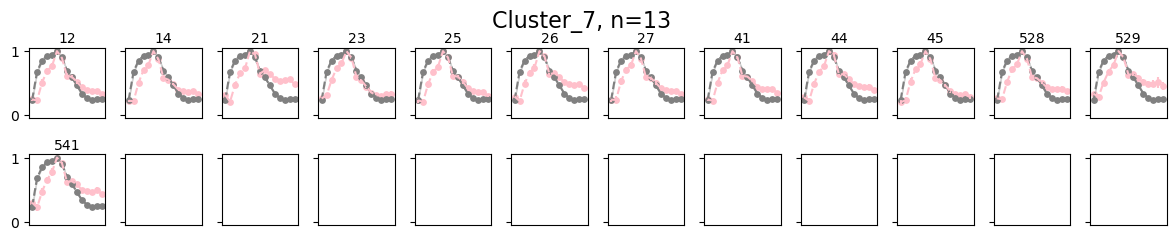

In [37]:
plot_clustered_logD_plots(7,
                              save=True,
                              jupyter_display = False)

In [ ]:
return_information('ID-6', 534, 'Sequence..SP.Removed.', df_cleaned_umap_result)


## Display Grid Plots for All Clusters

In [ ]:
# for i in tqdm(range(len(cluster_dfs_avg))):  
#     plot_clustered_logD_plots(i,
#                               save='02-07-2024',
#                               jupyter_display = False)

## DATA PROCESSING STEP 5 (computer average logD per cluster)

In [ ]:
# Calculate cluster averages and standard deviations
df_cluster_avg_profiles = []
df_cluster_std_profiles = []
for i in range(len(cluster_dfs_avg)):
    cluster_REE_average = cluster_dfs_avg[i].iloc[1:, 1:].mean()
    cluster_REE_std = cluster_dfs_avg[i].iloc[1:, 1:].std()
    df_cluster_avg_profiles.append(cluster_REE_average)
    df_cluster_std_profiles.append(cluster_REE_std)

### Individual Scatter per Cluster

In [ ]:
for i in tqdm(range(len(cluster_dfs_avg))):  # Adjusted loop range
    ylabel = "Normalized LogD" if i % 4 == 0 else None  # Determine whether to display ylabel
    scatterplot_with_average(df_cluster_avg_profiles[i], 
                             df_cluster_std_profiles[i], 
                             np.mean(df_logD_avg.iloc[MexLanM1:MexLanM3+1], axis=0), 
                             df_logD_avg.iloc[MexLanM1:MexLanM3+1], 
                         title=f'Cluster {i}', xlabel=None, ylabel=ylabel, show_REE_label=True, 
                         sample_std_shade=True)
#     plt.savefig(f"02-21-2024, Representative Profile of Cluster {i}.svg", format = 'svg')
#     plt.savefig(f"02-21-2024, Representative Profile of Cluster {i}.tiff", format = 'tiff')    

In [ ]:
def scatterplot_with_average2(df, df_row1, yerr, df_row2, avg_row, title, 
                              xlabel, ylabel, cluster_index, hline=None, ax=None, show_REE_label=None, sample_std_shade=False,savefig=False):
    if ax is None:
        plt.figure(figsize=(2.5,2.5), dpi=150)
        plt.subplots_adjust(hspace=5)
        ax = plt.gca()

    avg_values = avg_row.mean(axis=0)
    std_values = avg_row.std(axis=0)
    
    # Define the color palette using Seaborn's Set2 palette
    palette = sns.color_palette("Set2", n_colors=8)  # Assume 8 clusters, adjust if needed
    color = palette[cluster_index]  # Assign the color based on the cluster index
    
    # Plot all proteins for each cluster as thin gray lines with a lower zorder (behind other elements)
    for index, row in df.iterrows():
        ax.plot(neutral_REE_header, row, color='lightgray', linestyle='-', linewidth=0.5, alpha=0.45, zorder=1)
    
    # Plot the average with shaded area for standard deviation with a medium zorder
    ax.fill_between(neutral_REE_header, avg_values - std_values, avg_values + std_values,
                    color='gray', alpha=0.5, label='Average ± 1 SD', zorder=4)
    
    # Plot the first row with error bars using the assigned cluster color with a higher zorder
    ax.scatter(neutral_REE_header, df_row1, label=f'Cluster {cluster_index}', color=color, s=15, zorder=3)
    if not sample_std_shade:
        ax.errorbar(neutral_REE_header, df_row1, yerr=yerr, color=color, ecolor=color, linestyle='--', zorder=3)
    else:
        ax.fill_between(neutral_REE_header, df_row1 - yerr, df_row1 + yerr,
                        color=color, alpha=0.3, label='Error ± 1 SD', zorder=4)
        ax.plot(neutral_REE_header, df_row1, label=f'Cluster {cluster_index}', color=color, linestyle='--', zorder=3)

    # Plot the second row as a black dotted line with a higher zorder
    ax.scatter(neutral_REE_header, df_row2, label='Row 2', color='black', s=15, zorder=2)
    ax.plot(neutral_REE_header, df_row2, label='Row 2', color='black', linestyle='--', zorder=2)

    # Add x-values next to the first row's scatter points
    if show_REE_label is not None:
        for i, txt in enumerate(neutral_REE_header):
            ax.annotate(txt, (neutral_REE_header[i], df_row1.iloc[i]),
                        textcoords="offset points", xytext=(0, -10), ha='center', fontsize=7, zorder=5)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_xticks([])
    ax.set_xticklabels([], rotation=45, ha="center")
    ax.set_ylim(-0.05, 1.05)

    # Add a horizontal line if specified
    if hline is not None:
        ax.axhline(y=hline, color='black', linestyle='--', label='Horizontal Line', zorder=6)

    # Move x-label to the top
    ax.xaxis.set_label_position('top')

    # Add legend
    # ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    if savefig:
        plt.savefig(f'08-30-2024, {title} Representative Profile (ULTIMATE).svg',format='svg')
    
    if ax is None:
        plt.show()


In [ ]:
for i in tqdm(range(len(cluster_dfs_avg))):  # Adjusted loop range
    ylabel = "Normalized LogD" #if i % 4 == 0 else None  # Determine whether to display ylabel

    # Use the new scatterplot_with_average2 function
    scatterplot_with_average2(
        df=cluster_dfs_avg[i].iloc[1:, 1:],  # Pass the dataframe for the cluster profiles
        df_row1=df_cluster_avg_profiles[i],  # Cluster average profile
        yerr=df_cluster_std_profiles[i],  # Cluster standard deviation profile
        df_row2=np.mean(df_logD_avg.iloc[MexLanM1:MexLanM3+1], axis=0),  # Average of selected rows
        avg_row=df_logD_avg.iloc[MexLanM1:MexLanM3+1],  # Dataframe with selected rows
        title=f'Cluster {i}', 
        xlabel=None, 
        ylabel=ylabel, 
        cluster_index=i,  # Pass the cluster index for color assignment
        show_REE_label=True, 
        sample_std_shade=True,
        savefig=True
    )

### Grid Plot for all Representative Profiles

In [ ]:
# Create a 4x3 grid of subplots
fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True, dpi=100)

# Flatten the axes array to iterate over each subplot
axes = axes.flatten()

# Iterate over each cluster and plot the corresponding scatterplot
for i in tqdm(range(len(cluster_dfs_avg))):  # Adjusted loop range
    ylabel = "Normalized LogD" if i % 3 == 0 else None  # Determine whether to display ylabel
    scatterplot_with_average(df_cluster_avg_profiles[i],
                             df_cluster_std_profiles[i],
                             np.mean(df_logD_avg.iloc[MexLanM1:MexLanM3+1], axis=0), 
                             df_logD_avg.iloc[MexLanM1:MexLanM3+1],  
                             title=f'Cluster {i}', xlabel=None, ylabel=ylabel, show_REE_label=True, 
                             sample_std_shade=True, ax=axes[i])

# Adjust layout and show the plots
# plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Reduce the padding between subplots
# plt.savefig("02-15-2024, Representative Profiles of Clusters.svg", format='svg')
# plt.savefig("02-15-2024, Representative Profiles of Clusters.tiff", format='tiff')
plt.show()


### Export the Data for Each Cluster

In [ ]:
# Assuming df is your original DataFrame and indices_cluster5 is a list of indices
# Create a new DataFrame based on the indices provided in indices_cluster5
df_cluster4 = df.loc[cluster_indices[4]]

# Display the new DataFrame
print(df_cluster4['Sequence (SP Removed)'])

In [ ]:
df_cluster4.to_csv('df_cluster4_AAseqs.csv', index=False)